In [4]:
import os
from datetime import datetime, date
from sklearn import utils
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as fn
import torch.optim as optim
import tensorflow as tf
from tensorflow import keras

device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
plt.style.use('ggplot')

### 0. Utils

### 1-1. Preprocessor

In [5]:
class Preprocessor:
    def _fit_transform(self, raw):
        result = raw.copy()

        result = self._n_comment_to_float(result)
        result = self._str_to_datetype(result)
        result = self._add_n_hashtag(result)
        
        self.non_numeric = ['channel', 'title', 'genre', 'description', 'date', 'sign_in']
        result = self._merge(result, self.non_numeric)
        
        features = ['cumul_view', 'n_dislike', 'n_like', 'n_comment', 'video_n_view', 'cumul_subs']
        new_name = ['view_diff', 'dislike_diff', 'like_diff', 'comment_diff', 'video_n_view_diff', 'sub_diff']
        result = self._add_diff(result, features, new_name)
        
        result = self._add_no_upload_interval(result)
        result = self._remove_nan(result)
        self._one_hot(result)

        return result
        
        
        
    #FEATRUES TO ADD & MODIFY
    ####################################################################     
    def _n_comment_to_float(self,result):
        idx1 = result['n_comment'] == '댓글 사용 중지'
        idx2 = result.n_comment.isna()
        idx = idx1|idx2
        result['n_comment'].loc[idx] = result['n_comment'].loc[idx].apply(lambda x: 0)
        result['n_comment'] = result['n_comment'].astype(float)
        return result
        
    
    def _str_to_datetype(self,result):
        if pd.api.types.is_datetime64_ns_dtype(result['date']):
            pass
        else:
            result['date'] = pd.to_datetime(result['date'])
        return result
    
    
    def _add_n_hashtag(self,result):
        result['n_hashtage'] = 0
        idx = result['description'].notnull()
        result.loc[idx, 'n_hashtage'] = result.loc[idx, 'description'].apply(lambda x: len(x.split('#'))-1)
        return result
        
    
    @staticmethod
    def _get_to_merge(data, numeric, non_numeric):
        data = data.reset_index(drop=True)
        num_to_add = data.title.shape[0] - data.title.isna().sum()
        data = pd.concat((data.loc[0,non_numeric], data[numeric].mean()))
        data['video_num'] = num_to_add
        return data
    def _merge(self, result, non_numeric):
        #operate both merge and creating video_num featrue simultaneously.
        numeric = [col for col in result.columns.tolist() if col not in non_numeric]
        return result.groupby(['channel', 'date']).apply(lambda x: self._get_to_merge(x, numeric, non_numeric)).reset_index(drop=True)
    
    
    @staticmethod
    def _get_diff(result, feature, new_name):
        result = result.reset_index(drop=True)
        result[new_name] = (result[feature] - result[feature].shift())
        return result
    def _add_diff(self, result, feature, new_name):
        result = result.groupby('channel').apply(lambda x: self._get_diff(x, feature, new_name)).reset_index(drop=True)
        result[new_name] = result[new_name].fillna(0)
        return result
    
    
    @staticmethod
    def _get_no_upload_interval(result):
        result = result.reset_index(drop=True)
        upload_idx = result[result['video_num'] != 0].index.tolist()
        temp = [0 for i in range(result.shape[0])]
        for i in range(len(upload_idx)):
            if i == len(upload_idx)-1:
                former = upload_idx[i]
                temp[former+1:] = [i+1 for i in range(len(temp[former+1:]))]
            else:
                former, latter = upload_idx[i], upload_idx[i+1]
                temp[former+1:latter] = [i+1 for i in range(len(temp[former+1:latter]))]
        result['no_upload_interval'] = temp
        return result
    def _add_no_upload_interval(self,result):
        return result.groupby('channel').apply(lambda x: self._get_no_upload_interval(x)).reset_index(drop=True)
    
    
    def _remove_nan(self, result):
        numeric = [col for col in result.columns.tolist() if col not in self.non_numeric]
        result.loc[:, numeric] = result.loc[:,numeric].fillna(0)
        return result
    
    
    def _one_hot(self, data):
        data.loc[:,'genre'] = data.genre.fillna('etc')
        genre = data.genre.unique().tolist()
        for i, name in enumerate(genre):
            data.genre[data.genre==name] = data.genre[data.genre==name].apply(lambda x: i)
            
        one_hot = pd.get_dummies(data.genre.unique().tolist())
        data['one_hot'] = data.genre
        for i in range(len(one_hot)):
            data.loc[data.genre==i,'one_hot'] = data.loc[data.genre==i, 'genre'].apply(lambda x: one_hot[i].values)
    ####################################################################
    
    
    
    #CREATE SEQUENTIAL DATA
    ####################################################################
    def _extract_at_least_filter(self, result, filter_size):
        #fillter_size 이상인 채널 추출하기
        alive_idx = result['channel'].value_counts() >= filter_size
        alive_array = alive_idx[alive_idx==True].index
        return result[result['channel'].isin(alive_array)].reset_index(drop=True)
    
    
    @staticmethod
    def _to_sequential(result, filter_size, target_size, stride, features, target_features):
        result = result.reset_index(drop=True)
        idx_list = result.index.tolist()
        
        train, target = [],[]
        for i in range((len(idx_list)-filter_size-target_size)//stride +1):
            train_idx = idx_list[i*stride : i*stride + filter_size]
            target_idx = idx_list[i*stride + filter_size : i*stride + filter_size + target_size]
            train_temp = result.loc[train_idx,:].values.reshape(1,-1)
            target_temp = result.loc[target_idx,target_features].values.reshape(1,-1)
            
            train = train_temp.copy() if i == 0 else np.vstack([train, train_temp])
            target = target_temp.copy() if i == 0 else np.vstack([target, target_temp])
            
        train = pd.DataFrame(train, columns = result.columns.tolist()*filter_size)
        target = pd.DataFrame(target, columns = target_features*target_size)
        return train[features], target
    def _create_sequential_data(self, result, filter_size=7, target_size=1, stride=1, features=None, target_features=None):
        #remove channels with few information with respect to filter_size and target_size to extract
        result = self._extract_at_least_filter(result, filter_size + target_size)
        
        #features: features to drop fromf X (features)
        #target_features: features to extract from Y (targets)
        if features is None:
            features = ['date', 'genre','title', 'channel', 'description',	'sign_in', 'current_cumul_view', 'current_n_video', 'current_cumul_subs']
        if target_features is None:
            target_features = ['sub_diff']
        
        #return train, target set wrt groups
        result = result.groupby('channel').apply(lambda x: self._to_sequential(x, filter_size, target_size, stride, features, target_features)).reset_index(drop=True)
        return self._combine(result)
    
    
    def _combine(self, result):
        temp0, temp1 = [], []
        for i in range(len(result)):
            temp0.append(result[i][0])
            temp1.append(result[i][1])
        temp0 = pd.concat(temp0)
        temp1 = pd.concat(temp1)
        return (temp0, temp1)
    ####################################################################


    
    #SCALE
    ####################################################################
    def scale(self, data, return_original_scale=True):
        original_scale = pd.concat((data.max(), data.min()), axis=1).T
        original_scale.index=['max', 'min']
        scaler = preprocessing.MinMaxScaler()
        data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
        if return_original_scale:
            return data, original_scale
        return data
    
        
    def inverse_scale(self, pred, scl):
        for idx in range(pred.shape[1]):
            pred.iloc[:,idx] = (scl.iloc[0,idx]-scl.iloc[1,idx])*pred.iloc[:,idx]+scl.iloc[1,idx]

### 1-2. Data Loader

In [6]:
class Loader(Preprocessor):
    def __init__(self, path):
        self._raw = pd.read_csv(path)
        self.data = super()._fit_transform(self._raw.copy())
        print('Data Loaded. :P')
        
        
    def get_data(self, filter_size=7, target_size=1, stride=1, features=None, target_features=None,
                         channel:list=None, shuffle=False, random_state=None, order=None):
        if channel is None:
            data_to_extract = self.data
        else:
            channels = self.list_channel[channel].tolist()
            data_to_extract = self.data.set_index('channel').loc[channels].reset_index()
            
        train, target = self._create_sequential_data(data_to_extract, filter_size, target_size, stride, features, target_features)
        if shuffle:
            train, target = utils.shuffle(train, target, random_state=random_state)
        
        if order:
            train_col = [col for col in train.columns.unique().tolist()]
            target_col = [col for col in target.columns.unique().tolist()]
            train, target = train[train_col], target[target_col]
            
        return train, target

    
    @property
    def list_features(self):
        #list the entire features, hence you can choose which features are included in whole set.
        return self.data.columns.tolist()
    
    @property
    def list_channel(self):
        #list indices of channel.
        return pd.Series(self.data.channel.unique().tolist())

### Changes
-------------

#### 1. Features
Before
```
loader.get_data(filter_size, target_size, stride, drop_features)
```
<br>

After
```
loader.get_data(filter_size, target_size, stride, features)
```
Input a ```list``` of features to use in trainset, instead of features to drop out of it.

<br>

#### 2. Genre Encoding

New feature ```one_hot``` contains one-hot encoded genre data

In [7]:
#path = '/home/mskang/CapstoneUOS/raw/train_raw_LITE.csv'
path = '/home/mskang/CapstoneUOS/raw/meta_trend_data(201130).csv'
loader = Loader(path)

/home/mskang/wheresmydog/Cancer/venv/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/mskang/wheresmydog/Cancer/venv/lib/python3.6/site-packages/ipykernel_launcher.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Data Loaded. :P


> load함수

In [8]:
def load(
    filter_size: '60, 90, 180', 
    target_size: '1, 7, 30, 180', 
    stride: '1, 2, 3',
    drop_suffix: '각 변수 끝에 붙은 번호를 제거할지 여부'=True,
    path='/home/mskang/CapstoneUOS/notebooks/ModelResearch_iloveslowfood/data_variants'):
    
    print(f'Setting: filter_size({filter_size})\ttarget_size({target_size})\tstride({stride})\tdrop_suffix({drop_suffix})')
    X_name = f'fs({filter_size})_ts({target_size})_st({stride}).csv'
    y_name = f'fs({filter_size})_ts({target_size})_st({stride})_label.csv'
    
    print('Load feature data...', end='\t')
    X = pd.read_csv(os.path.join(path, X_name))
    print('loaded!')
    print('Load label data...', end='\t')
    y = pd.read_csv(os.path.join(path, y_name))
    print('loaded!')
    
    if drop_suffix:
        X.columns = list(map(lambda x: x.split('.')[0], X.columns.tolist()))
        y.columns = list(map(lambda x: x.split('.')[0], y.columns.tolist()))
    return X, y

> 데이터 불러오기

In [9]:
filter_size = 90
target_size = 30
stride = 1
X_90_30, y_90_30 = load(filter_size, target_size, stride)

Setting: filter_size(90)	target_size(30)	stride(1)	drop_suffix(True)
Load feature data...	loaded!
Load label data...	loaded!


In [10]:
filter_size = 180
target_size = 30
stride = 1
X_180_30, y_180_30 = load(filter_size, target_size, stride)

Setting: filter_size(180)	target_size(30)	stride(1)	drop_suffix(True)
Load feature data...	loaded!
Load label data...	loaded!


In [11]:
filter_size = 90
target_size = 90
stride = 1
X_90_90, y_90_90 = load(filter_size, target_size, stride)

Setting: filter_size(90)	target_size(90)	stride(1)	drop_suffix(True)
Load feature data...	loaded!
Load label data...	loaded!


In [12]:
filter_size = 180
target_size = 90
stride = 1
X_180_90, y_180_90 = load(filter_size, target_size, stride)

Setting: filter_size(180)	target_size(90)	stride(1)	drop_suffix(True)
Load feature data...	loaded!
Load label data...	loaded!


In [13]:
filter_size = 90
target_size = 1
stride = 1
X_90_1, y_90_1 = load(filter_size, target_size, stride)

Setting: filter_size(90)	target_size(1)	stride(1)	drop_suffix(True)
Load feature data...	loaded!
Load label data...	loaded!


In [14]:
filter_size = 180
target_size = 1
stride = 1
X_180_1, y_180_1 = load(filter_size, target_size, stride)

Setting: filter_size(180)	target_size(1)	stride(1)	drop_suffix(True)
Load feature data...	loaded!
Load label data...	loaded!


## 모델비교



>Full Preprocessing

In [21]:
from sklearn.preprocessing import MinMaxScaler

#scaler_y=preprocessing.MinMaxScaler()
def fit_3d(x_train,x_val,x_test, opt=0):
    
    x_train_sample = x_train.shape[0] #샘플 개수
    x_val_sample=x_val.shape[0]
    x_test_sample=x_test.shape[0]
    
    x_timestep = x_train.shape[1] # timestep
    x_feature = x_train.shape[2]# feature 차원 
    scaler=MinMaxScaler()
    for ss in range(x_timestep):
        scaler.partial_fit(x_train[:, ss, :]) # 순회피팅

    results1,results2,results3=([],[],[])
    for ss in range(x_timestep):
        results1.append(scaler.transform(x_train[:, ss, :]).reshape(x_train_sample, 1, x_feature))
        results2.append(scaler.transform(x_val[:,ss,:]).reshape(x_val_sample,1,x_feature))
        results3.append(scaler.transform(x_test[:,ss,:]).reshape(x_test_sample,1,x_feature))
    df_train_scaled = np.concatenate(results1, axis=1) #합치기.
    df_val_scaled=np.concatenate(results2,axis=1)
    df_test_scaled=np.concatenate(results3,axis=1)
    
    if opt:
        return df_train_scaled,df_val_scaled,df_test_scaled,scaler
    return df_train_scaled,df_val_scaled,df_test_scaled

In [22]:
def stack_to_multi(df):
    feature_num=len(set(df.columns))
    window_num=int(df.shape[1]/feature_num)
    sample_num=int(df.shape[0])
    temp=np.empty([sample_num,window_num,feature_num])
    for i in range(feature_num):
        temp[:,:,i]=df.iloc[:,window_num*i:window_num*i+window_num]
    
    return temp
    

In [23]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_absolute_error(Y_true[:, -1], Y_pred[:, -1]) #### <<- 

In [24]:
def preprocess_for_score(X,y,target_size):
    random_state = 42
    test_size = 0.2

    X_trn, X_test, y_trn, y_test = train_test_split(
    X, y, 
    shuffle=True, 
    test_size=test_size, 
    random_state=random_state
    ) 

    X_train, X_valid, y_train, y_valid = train_test_split(
    X_trn, y_trn, 
    shuffle=True, 
    test_size=test_size, 
    random_state=random_state
    ) 
    
    X_train_3d=stack_to_multi(X_train)
    X_valid_3d=stack_to_multi(X_valid)
    X_test_3d=stack_to_multi(X_test)
    
    X_train_scaled,X_valid_scaled,X_test_scaled,scaler=fit_3d(X_train_3d, X_valid_3d, X_test_3d,opt=1) #scaler도 받자.
    
    X_train_subdiff=X_train['sub_diff']
    X_valid_subdiff=X_valid['sub_diff']
    X_test_subdiff=X_test['sub_diff']

    # (샘플개수 , (180+30)의 TARGET
    temp1=pd.concat([X_train_subdiff,y_train],axis=1)
    temp2=pd.concat([X_valid_subdiff,y_valid],axis=1)
    temp3=pd.concat([X_test_subdiff,y_test],axis=1)

    # (샘플, timestep, targetsize)
    y_train_3d=np.empty((X_train_subdiff.shape[0],X_train_subdiff.shape[1],target_size)) # 30 : targetsize
    y_valid_3d=np.empty((X_valid_subdiff.shape[0],X_valid_subdiff.shape[1],target_size))
    y_test_3d=np.empty((X_test_subdiff.shape[0],X_test_subdiff.shape[1],target_size))

    for t in range(X_train_subdiff.shape[1]): # 180 Timestep
        y_train_3d[:,t]=temp1.iloc[:,t:t+target_size]
        y_valid_3d[:,t]=temp2.iloc[:,t:t+target_size]
        y_test_3d[:,t]=temp3.iloc[:,t:t+target_size]

    y_train_temp=y_train_3d.reshape(-1,1)
    y_valid_temp=y_valid_3d.reshape(-1,1)
    y_test_temp=y_test_3d.reshape(-1,1)

    scaler_y=MinMaxScaler()
    y_train_scaled=scaler_y.fit_transform(y_train_temp)
    y_val_scaled=scaler_y.transform(y_valid_temp)
    y_test_scaled=scaler_y.transform(y_test_temp)

    y_train_scaled=y_train_scaled.reshape(y_train_3d.shape[0],y_train_3d.shape[1],y_train_3d.shape[2])
    y_valid_scaled=y_val_scaled.reshape(y_valid_3d.shape[0],y_valid_3d.shape[1],y_valid_3d.shape[2])
    y_test_scaled=y_test_scaled.reshape(y_test_3d.shape[0],y_test_3d.shape[1],y_test_3d.shape[2])
    
    return (X_train_scaled,X_valid_scaled,X_test_scaled,y_train_scaled,y_valid_scaled,y_test_scaled,
            scaler,scaler_y)


In [25]:
filter_size=[90,180]
target_size=[1,30,90]

In [26]:
import sys , numpy as np
mod = sys.modules[__name__]

> Inverse를 위한 scaler 저장

In [27]:
for fil in filter_size:
    for target in target_size:

        [globals()[('X_{}_{}_train'.format(fil,target))],globals()[('X_{}_{}_valid'.format(fil,target))],
         globals()[('X_{}_{}_test'.format(fil,target))],globals()[('y_{}_{}_train'.format(fil,target))],
                  globals()[('y_{}_{}_valid'.format(fil,target))],globals()[('y_{}_{}_test'.format(fil,target))],
        globals()['scaler_{}_{}'.format(fil,target)],globals()['scaler_y_{}_{}'.format(fil,target)]]=preprocess_for_score(getattr(mod,  'X_{}_{}'.format(fil,target)),
                                                                                     getattr(mod,  'y_{}_{}'.format(fil,target)),target)



In [30]:
for fil in filter_size:
    for target in target_size:
        print(getattr(mod, 'X_{}_{}_train'.format(fil,target)).shape, 'X_{}_{}_train'.format(fil,target)) 
        print(getattr(mod, 'X_{}_{}_valid'.format(fil,target)).shape, 'X_{}_{}_valid'.format(fil,target)) 
        print(getattr(mod, 'X_{}_{}_test'.format(fil,target)).shape, 'X_{}_{}_test'.format(fil,target)) 
        print(getattr(mod, 'y_{}_{}_train'.format(fil,target)).shape, 'y_{}_{}_train'.format(fil,target)) 
        print(getattr(mod, 'y_{}_{}_valid'.format(fil,target)).shape, 'y_{}_{}_valid'.format(fil,target)) 
        print(getattr(mod, 'y_{}_{}_test'.format(fil,target)).shape, 'y_{}_{}_test'.format(fil,target)) 

(121872, 90, 17) X_90_1_train
(30468, 90, 17) X_90_1_valid
(38085, 90, 17) X_90_1_test
(121872, 90, 1) y_90_1_train
(30468, 90, 1) y_90_1_valid
(38085, 90, 1) y_90_1_test
(101780, 90, 17) X_90_30_train
(25445, 90, 17) X_90_30_valid
(31807, 90, 17) X_90_30_test
(101780, 90, 30) y_90_30_train
(25445, 90, 30) y_90_30_valid
(31807, 90, 30) y_90_30_test
(65849, 90, 17) X_90_90_train
(16463, 90, 17) X_90_90_valid
(20579, 90, 17) X_90_90_test
(65849, 90, 90) y_90_90_train
(16463, 90, 90) y_90_90_valid
(20579, 90, 90) y_90_90_test
(65317, 180, 17) X_180_1_train
(16330, 180, 17) X_180_1_valid
(20412, 180, 17) X_180_1_test
(65317, 180, 1) y_180_1_train
(16330, 180, 1) y_180_1_valid
(20412, 180, 1) y_180_1_test
(50980, 180, 17) X_180_30_train
(12745, 180, 17) X_180_30_valid
(15932, 180, 17) X_180_30_test
(50980, 180, 30) y_180_30_train
(12745, 180, 30) y_180_30_valid
(15932, 180, 30) y_180_30_test
(26876, 180, 17) X_180_90_train
(6720, 180, 17) X_180_90_valid
(8399, 180, 17) X_180_90_test
(26876,

### ConvGRU - evaluation

In [39]:
for fil in filter_size:
    for target in target_size:
        path='Checkpoint/'+'ConvGRU({}_{}_1).h5'.format(fil, target)
        loaded_model = tf.keras.models.load_model(path,custom_objects={'customLoss1':last_time_step_mse},compile=False)
        loaded_model.compile(optimizer='adam', loss='mae',metrics=[last_time_step_mse])
        
        globals()['predict_{}_{}_temp'.format(fil,target)]=loaded_model.predict(getattr(mod,'X_{}_{}_test'.format(fil,target)))
        globals()['predict_{}_{}'.format(fil,target)]=getattr(mod,'predict_{}_{}_temp'.format(fil,target))[:,-1,:] # 마지막 step의 예측값
        globals()['truth_{}_{}'.format(fil,target)]=getattr(mod,'y_{}_{}_test'.format(fil,target))[:,-1,:]# 마지막 step의 실제값

        globals()['rescaled_predict_{}_{}'.format(fil,target)]=getattr(mod,'scaler_y_{}_{}'.format(fil,target)).inverse_transform(getattr(mod,'predict_{}_{}'.format(fil,target))) # 역스케일링
        globals()['rescaled_truth_{}_{}'.format(fil,target)]=getattr(mod,'scaler_y_{}_{}'.format(fil,target)).inverse_transform(getattr(mod,'truth_{}_{}'.format(fil,target))) # 역스케일링
                                                                                                                                
        print('{}_{}_rmse : '.format(fil,target),np.sqrt(np.mean(keras.metrics.mean_squared_error(getattr(mod,'rescaled_predict_{}_{}'.format(fil,target))[:],getattr(mod,'rescaled_truth_{}_{}'.format(fil,target))[:]))))
        print('{}_{}_mae : '.format(fil,target),np.mean(keras.metrics.mean_absolute_error(getattr(mod,'rescaled_predict_{}_{}'.format(fil,target))[:],getattr(mod,'rescaled_truth_{}_{}'.format(fil,target))[:])))
        print('{}_{}_rmse : '.format(fil,target),np.sqrt(keras.metrics.mean_squared_error(getattr(mod,'rescaled_predict_{}_{}'.format(fil,target))[:,-1],getattr(mod,'rescaled_truth_{}_{}'.format(fil,target))[:,-1])))
        print('{}_{}_mae : '.format(fil,target),np.mean((keras.metrics.mean_absolute_error(getattr(mod,'rescaled_predict_{}_{}'.format(fil,target))[:,-1],getattr(mod,'rescaled_truth_{}_{}'.format(fil,target))[:,-1]))))
                                                                                                                                
        

90_1_rmse :  176.76738311425746
90_1_mae :  13.464072468893546
90_1_rmse :  176.76738311425746
90_1_mae :  13.46407246889355
90_30_rmse :  1446.6832070288829
90_30_mae :  132.96197832813684
90_30_rmse :  1410.7535683380486
90_30_mae :  155.41578953857987
90_90_rmse :  1522.2083240374484
90_90_mae :  175.6076542025242
90_90_rmse :  1821.9097927792784
90_90_mae :  222.76009595815594
180_1_rmse :  2822.5864280887386
180_1_mae :  291.0099313422934
180_1_rmse :  2822.586428088739
180_1_mae :  291.0099313422934
180_30_rmse :  2366.5416613543016
180_30_mae :  242.00020416510762
180_30_rmse :  1273.6483390102835
180_30_mae :  232.85524158994042
180_90_rmse :  2686.206902665641
180_90_mae :  238.45614545702966
180_90_rmse :  2575.5169838218744
180_90_mae :  277.8200766454567


### 원본 데이터로 채널 당 plottting 진행

In [62]:
from sklearn.preprocessing import MinMaxScaler

#scaler_y=preprocessing.MinMaxScaler()
def fit_3d2(x_train):
    
    x_train_sample = x_train.shape[0] #샘플 개수
    x_timestep = x_train.shape[1] # timestep
    x_feature = x_train.shape[2]# feature 차원 
    scaler=MinMaxScaler()
    for ss in range(x_timestep):
        scaler.partial_fit(x_train[:, ss, :]) # 순회피팅

    results1=[]
    for ss in range(x_timestep):
        results1.append(scaler.transform(x_train[:, ss, :]).reshape(x_train_sample, 1, x_feature))

    df_train_scaled = np.concatenate(results1, axis=1) #합치기.
    return df_train_scaled,scaler


In [63]:
def preprocess_for_score2(X,y,target_size):
    
    X_train_3d=stack_to_multi(X)
    X_train_scaled,scaler=fit_3d2(X_train_3d)#scaler도 받자.
    X_train_subdiff=X['sub_diff']
    
    # (샘플개수 , (180+30)의 TARGET
    temp1=pd.concat([X_train_subdiff,y],axis=1)
    # (샘플, timestep, targetsize)
    y_train_3d=np.empty((X_train_subdiff.shape[0],X_train_subdiff.shape[1],target_size)) # 30 : targetsize

    for t in range(X_train_subdiff.shape[1]): # 180 Timestep
        y_train_3d[:,t]=temp1.iloc[:,t:t+target_size]

    y_train_temp=y_train_3d.reshape(-1,1)
    scaler_y=MinMaxScaler()
    y_train_scaled=scaler_y.fit_transform(y_train_temp)
    y_train_scaled=y_train_scaled.reshape(y_train_3d.shape[0],y_train_3d.shape[1],y_train_3d.shape[2])

    
    return X_train_scaled,y_train_scaled,scaler,scaler_y


> 채널 이름이 나타나있는 원본 데이터

In [35]:
data_180_1=loader.get_data(180,1,1, ['channel'])

In [36]:
data_180_30=loader.get_data(180,30,1, ['channel'])

In [37]:
data_180_90=loader.get_data(180,90,1, ['channel'])

In [38]:
data_90_90=loader.get_data(180,90,1, ['channel'])

> 개별 예측 진행하는 법

In [40]:
path='Checkpoint/'+'ConvGRU(180_1_1).h5'
loaded_model = tf.keras.models.load_model(path,custom_objects={'customLoss1':last_time_step_mse},compile=False)
loaded_model.compile(optimizer='adam', loss='mae',metrics=[last_time_step_mse])

In [ ]:
# rescaled_fitting
test=np.empty([16,90,17]) # 16 : 보려는 sample 개수,  90 : time step , 17 : feature num
for i in range(90): # 90 : timestep
    test[:,i,:]=scaler_90_30.inverse_transform(X_90_30_test[160:176,i,:])
    
test_predict_temp=loaded_model.predict(X_90_30_test[160:176]) # 예측값(scaled)
test_predict1=scaler_y_90_30.inverse_transform(test_predict_temp[:,-1,:]) # 마지막 step의 예측값(unscaled)
test_predict=np.concatenate([test[:,:,-2],test_predict1],axis=1) # 실제 값  + 예측값. # -2는 sub_diff의 위치.

real_target1=scaler_y_90_30.inverse_transform(y_90_30_test[160:176,-1,:])
real_target=np.concatenate([test[:,:,-2],real_target1],axis=1)

plt.figure(figsize=(16,24))
for i in range(len(real_target1)):
        plt.subplot(8,2,i+1)
        plt.plot(np.arange(1,filtersize+targetsize+1),test_predict[i,:],label='predict')
        plt.plot(np.arange(1,targetsize+filtersize+1),real_target[i],label='real')
        
        plt.legend()

> 채널별 fitting 진행하는 법

In [ ]:
path='Checkpoint/'+'Wavenet(90_30_1).h5'
loaded_model = tf.keras.models.load_model(path,custom_objects={'customLoss1':last_time_step_mse},compile=False)
loaded_model.compile(optimizer='adam', loss='mae',metrics=[last_time_step_mse])

In [ ]:
#data_90_30=loader.get_data(90,30,1, ['channel'])
"이는 channel별로 fitting하는 역할밖에 안 된다."
"data_90_30[0] :  X_90_30과 동일한 샘플, 단 feature로 channel만 가짐."
"data_90_30[1] : y_90_30과 동일차원.. "

(4, 90)


Text(0.5, 0, 'Days')

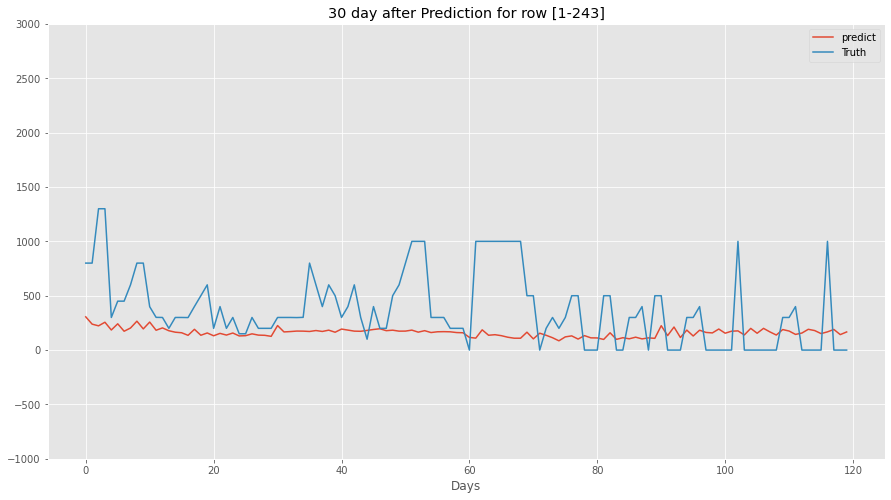

In [360]:
X2,y2,scaler_X2,scaler_y2=preprocess_for_score2(X_90_30.iloc[[3,33,63,93]], y_90_30.iloc[[3,33,63,93]], 30)# 데이터는 get_loaded 한경우
plt.figure(figsize=(15,8))

plt.plot(scaler_y2.inverse_transform(loaded_model.predict(X2)[:,-1].reshape(1,-1)).flatten(), label='predict') # 91일 ~ 끝까지. 
plt.plot(scaler_y2.inverse_transform(y2[:,-1].reshape(1,-1)).flatten(), label='Truth')
plt.ylim([-1000,3000])
plt.legend()

plt.title('30 day after Prediction for row [1-243]')
plt.xlabel('Days')

> 3D INVERSE SCALING

In [ ]:
# Inverse scaling
# 우선, 
sample_size=X_scaled.shape[0] # sample num
time_step=90
feature_num=17
X_raw=np.empty([sample_size,time_step,feature_num]) # 원본이 될 친구

for i in range(90):
    X_raw[:,i,:]=scaler.inverse_transform(X_scaled[:,i,:]) # 매 Timestep마다 각각 inverse_scaling 진행. 

### 각자 모델 fitting

>Wavenet(90_30_1).h5  (아래예시임, 사실filter는 512)  
Wavenet(90_30_1)(filter=20).h5  
Wavenet(90_90_1).h5  
Wavenet(90_90_1)(filter:180)(plus2)  
Wavenet(180_90_1)  
Wavenet(180_90_1)(filter:180).h5  (아직 안했음, 학습중)    
Wavenet(180_30_1)(filtersize:60)(plus).h5  
Wavenet(180_30_1).h5  
Wavenet(90_1_1).h5  
Wavenet(180_1_1).h5

> 모델불러오기(Wavenet(90_30_1).h5  (filter:512))

In [349]:
path='Checkpoint/'+'Wavenet(90_30_1).h5'
loaded_model = tf.keras.models.load_model(path,custom_objects={'customLoss1':last_time_step_mse},compile=False)
loaded_model.compile(optimizer='adam', loss='mae',metrics=[last_time_step_mse])

In [350]:
loaded_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_54 (Conv1D)           (None, None, 512)         17920     
_________________________________________________________________
conv1d_55 (Conv1D)           (None, None, 512)         524800    
_________________________________________________________________
conv1d_56 (Conv1D)           (None, None, 512)         524800    
_________________________________________________________________
conv1d_57 (Conv1D)           (None, None, 512)         524800    
_________________________________________________________________
conv1d_58 (Conv1D)           (None, None, 512)         524800    
_________________________________________________________________
conv1d_59 (Conv1D)           (None, None, 512)         524800    
_________________________________________________________________
conv1d_60 (Conv1D)           (None, None, 512)        

> no scaling mae, rmse

In [48]:
predict_90_30_temp=loaded_model.predict(X_90_30_test)
predict_90_30=predict_90_30_temp[:,-1,:] # 마지막 step의 예측값
truth_90_30=y_90_30_test[:,-1,:] # 마지막 step의 실제값

rescaled_predict_90_30=scaler_y_90_30.inverse_transform(predict_90_30) # 역스케일링
rescaled_truth_90_30=scaler_y_90_30.inverse_transform(truth_90_30) # 역스케일링


In [ ]:
rmse --> np.sqrt(np.mean(keras.metrics.mean_squared_error(predict_array, truth_array)
mae --> np.mean(keras.metrics.mean_absolute_error(predict_array, truth_array)

In [50]:
print('30일간의 rmse --> ',np.sqrt(np.mean(keras.metrics.mean_squared_error(rescaled_predict_90_30[:],rescaled_truth_90_30[:]))))
print('30일간의 mae --> ',np.mean(keras.metrics.mean_absolute_error(rescaled_predict_90_30[:],rescaled_truth_90_30[:])))
print('30일 뒤 하루의 rmse --> ',np.sqrt(keras.metrics.mean_squared_error(rescaled_predict_90_30[:,-1],rescaled_truth_90_30[:,-1])))
print('30일 뒤 하루의 mae --> ',np.mean((keras.metrics.mean_absolute_error(rescaled_predict_90_30[:,-1],rescaled_truth_90_30[:,-1]))))



30일간의 rmse -->  1384.030292278158
30일간의 mae -->  159.70039784470907
30일 뒤 하루의 rmse -->  1471.6276825082625
30일 뒤 하루의 mae -->  174.3042859079849


In [456]:
filtersize=90
targetsize=30

> Inverse scaling

In [ ]:
# Inverse scaling
# 우선, 
sample_size=X_scaled.shape[0] # sample num
time_step=90
feature_num=17
X_raw=np.empty([sample_size,time_step,feature_num]) # 원본이 될 친구

for i in range(90):A
    X_raw[:,i,:]=scaler.inverse_transform(X_scaled[:,i,:]) # 매 Timestep마다 각각 inverse_scaling 진행. 

fitting

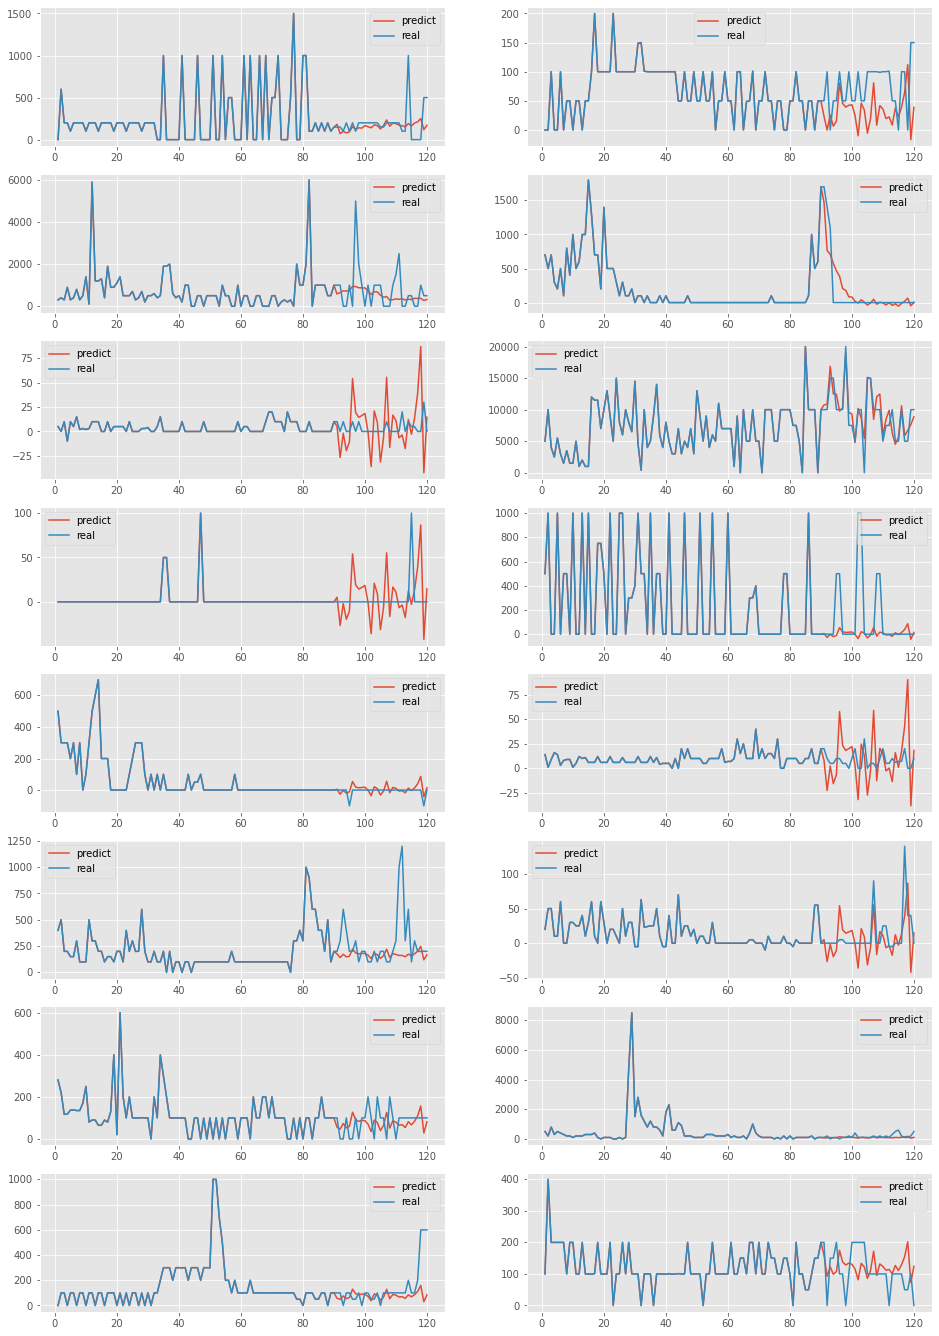

In [466]:
# rescaled_fitting
test=np.empty([16,90,17]) # 16 : 보려는 sample 개수,  90 : time step , 17 : feature num
for i in range(90): # 90 : timestep
    test[:,i,:]=scaler_90_30.inverse_transform(X_90_30_test[160:176,i,:])
    
test_predict_temp=loaded_model.predict(X_90_30_test[160:176]) # 예측값(scaled)
test_predict1=scaler_y_90_30.inverse_transform(test_predict_temp[:,-1,:]) # 마지막 step의 예측값(unscaled)
test_predict=np.concatenate([test[:,:,-2],test_predict1],axis=1) # 실제 값  + 예측값. # -2는 sub_diff의 위치.

real_target1=scaler_y_90_30.inverse_transform(y_90_30_test[160:176,-1,:])
real_target=np.concatenate([test[:,:,-2],real_target1],axis=1)

plt.figure(figsize=(16,24))
for i in range(len(real_target1)):
        plt.subplot(8,2,i+1)
        plt.plot(np.arange(1,filtersize+targetsize+1),test_predict[i,:],label='predict')
        plt.plot(np.arange(1,targetsize+filtersize+1),real_target[i],label='real')
        
        plt.legend()

> Full fitting

In [290]:
#data2=loader.get_data(90,30,1, ['channel'])

(4, 90)


Text(0.5, 0, 'Days')

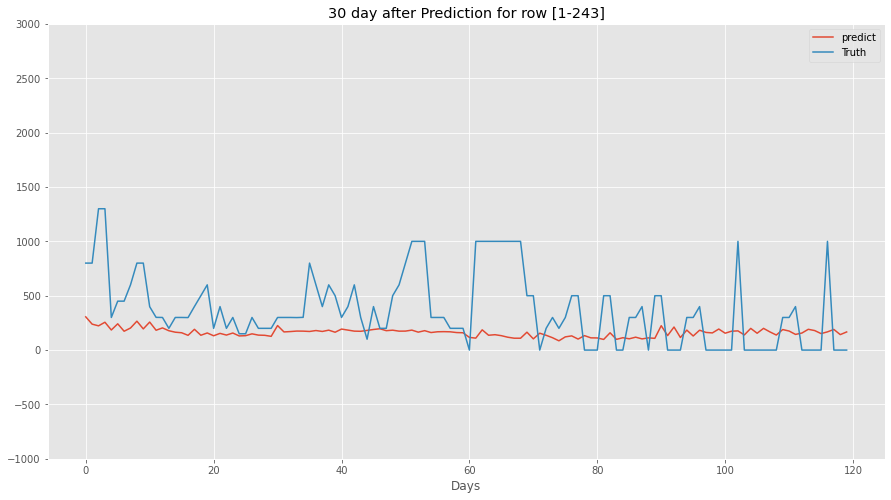

In [360]:
X2,y2,scaler_X2,scaler_y2=preprocess_for_score2(X_90_30.iloc[[3,33,63,93]], y_90_30.iloc[[3,33,63,93]], 30)# 데이터는 get_loaded 한경우
plt.figure(figsize=(15,8))

plt.plot(scaler_y2.inverse_transform(loaded_model.predict(X2)[:,-1].reshape(1,-1)).flatten(), label='predict') # 91일 ~ 끝까지. 
plt.plot(scaler_y2.inverse_transform(y2[:,-1].reshape(1,-1)).flatten(), label='Truth')
plt.ylim([-1000,3000])
plt.legend()

plt.title('30 day after Prediction for row [1-243]')
plt.xlabel('Days')

> 모델불러오기  
Wavenet(90_30_1)(filter=20).h5  

In [71]:
path='Checkpoint/'+'Wavenet(90_30_1)(filter=20).h5'
loaded_model = tf.keras.models.load_model(path,custom_objects={'customLoss1':last_time_step_mse},compile=False)
loaded_model.compile(optimizer='adam', loss='mae',metrics=[last_time_step_mse])

In [72]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 20)          700       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 20)          820       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 20)          820       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 20)          820       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 20)          820       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 20)          820       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 20)          8

> no scaling mae, rmse

In [26]:
predict_90_30_temp=loaded_model.predict(X_90_30_test)
predict_90_30=predict_90_30_temp[:,-1,:] # 마지막 step의 예측값
truth_90_30=y_90_30_test[:,-1,:] # 마지막 step의 실제값

rescaled_predict_90_30=scaler_y_90_30.inverse_transform(predict_90_30) # 역스케일링
rescaled_truth_90_30=scaler_y_90_30.inverse_transform(truth_90_30) # 역스케일링


NameError: name 'X_90_30_test' is not defined

In [240]:
print('30일간의 rmse --> ',np.sqrt(np.mean(keras.metrics.mean_squared_error(rescaled_predict_90_30[:],rescaled_truth_90_30[:]))))
print('30일간의 mae --> ',np.mean(keras.metrics.mean_absolute_error(rescaled_predict_90_30[:],rescaled_truth_90_30[:])))
print('30일 뒤 하루의 rmse --> ',np.sqrt(keras.metrics.mean_squared_error(rescaled_predict_90_30[:,-1],rescaled_truth_90_30[:,-1])))
print('30일 뒤 하루의 mae --> ',np.mean((keras.metrics.mean_absolute_error(rescaled_predict_90_30[:,-1],rescaled_truth_90_30[:,-1]))))



30일간의 rmse -->  1840.9453628878532
30일간의 mae -->  205.5778772329554
30일 뒤 하루의 rmse -->  1650.4313634652713
30일 뒤 하루의 mae -->  217.29568642132986


> 모델불러오기 Wavenet(90_90_1).h5'

In [73]:
path='Checkpoint/'+'Wavenet(90_90_1).h5'
loaded_model = tf.keras.models.load_model(path,custom_objects={'customLoss1':last_time_step_mse},compile=False)
loaded_model.compile(optimizer='adam', loss='mae',metrics=[last_time_step_mse])

In [74]:
loaded_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, None, 20)          700       
_________________________________________________________________
conv1d_19 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_20 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_21 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_22 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_23 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_24 (Conv1D)           (None, None, 20)         

> no scaling mae, rmse

In [242]:
predict_90_90_temp=loaded_model.predict(X_90_90_test)
predict_90_90=predict_90_90_temp[:,-1,:] # 마지막 step의 예측값
truth_90_90=y_90_90_test[:,-1,:] # 마지막 step의 실제값

rescaled_predict_90_90=scaler_y_90_90.inverse_transform(predict_90_90) # 역스케일링
rescaled_truth_90_90=scaler_y_90_90.inverse_transform(truth_90_90) # 역스케일링


In [243]:
print('30일간의 rmse --> ',np.sqrt(np.mean(keras.metrics.mean_squared_error(rescaled_predict_90_90[:],rescaled_truth_90_90[:]))))
print('30일간의 mae --> ',np.mean(keras.metrics.mean_absolute_error(rescaled_predict_90_90[:],rescaled_truth_90_90[:])))
print('30일 뒤 하루의 rmse --> ',np.sqrt(keras.metrics.mean_squared_error(rescaled_predict_90_90[:,-1],rescaled_truth_90_90[:,-1])))
print('30일 뒤 하루의 mae --> ',np.mean((keras.metrics.mean_absolute_error(rescaled_predict_90_90[:,-1],rescaled_truth_90_90[:,-1]))))



30일간의 rmse -->  1687.7992233474122
30일간의 mae -->  233.1989439745746
30일 뒤 하루의 rmse -->  1972.998995032117
30일 뒤 하루의 mae -->  271.0682701661806


> 모델불러오기(Wavenet(90_90_1)(filter:180)(plus2)  )

In [88]:
path6='Checkpoint/'+'Wavenet(90_90_1)(filter:180)(plus2).h5'
loaded_model6 = tf.keras.models.load_model(path6,custom_objects={'customLoss1':last_time_step_mse},compile=False)
loaded_model6.compile(optimizer='adam', loss='mae',metrics=[last_time_step_mse])

In [89]:
loaded_model6.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 180)         6300      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 180)         64980     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 180)         64980     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 180)         64980     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 180)         64980     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 180)         64980     
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 180)         6

In [438]:
predict_90_90_temp=loaded_model6.predict(X_90_90_test)
predict_90_90=predict_90_90_temp[:,-1,:] # 마지막 step의 예측값
truth_90_90=y_90_90_test[:,-1,:] # 마지막 step의 실제값

rescaled_predict_90_90=scaler_y_90_90.inverse_transform(predict_90_90) # 역스케일링
rescaled_truth_90_90=scaler_y_90_90.inverse_transform(truth_90_90) # 역스케일링


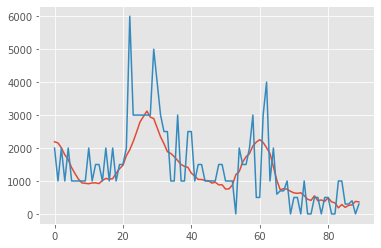

In [443]:
plt.plot(rescaled_predict_90_90[32])
plt.plot(rescaled_truth_90_90[32])

In [439]:
print('30일간의 rmse --> ',np.sqrt(np.mean(keras.metrics.mean_squared_error(rescaled_predict_90_90[:],rescaled_truth_90_90[:]))))
print('30일간의 mae --> ',np.mean(keras.metrics.mean_absolute_error(rescaled_predict_90_90[:],rescaled_truth_90_90[:])))
print('30일 뒤 하루의 rmse --> ',np.sqrt(keras.metrics.mean_squared_error(rescaled_predict_90_90[:,-1],rescaled_truth_90_90[:,-1])))
print('30일 뒤 하루의 mae --> ',np.mean((keras.metrics.mean_absolute_error(rescaled_predict_90_90[:,-1],rescaled_truth_90_90[:,-1]))))



30일간의 rmse -->  1426.0572981339246
30일간의 mae -->  184.86065142676884
30일 뒤 하루의 rmse -->  1076.2690917533444
30일 뒤 하루의 mae -->  216.56550572954117


>fitting

In [90]:
filtersize=90
targetsize=90

In [91]:
test_predict_temp.shape

(16, 180, 90)

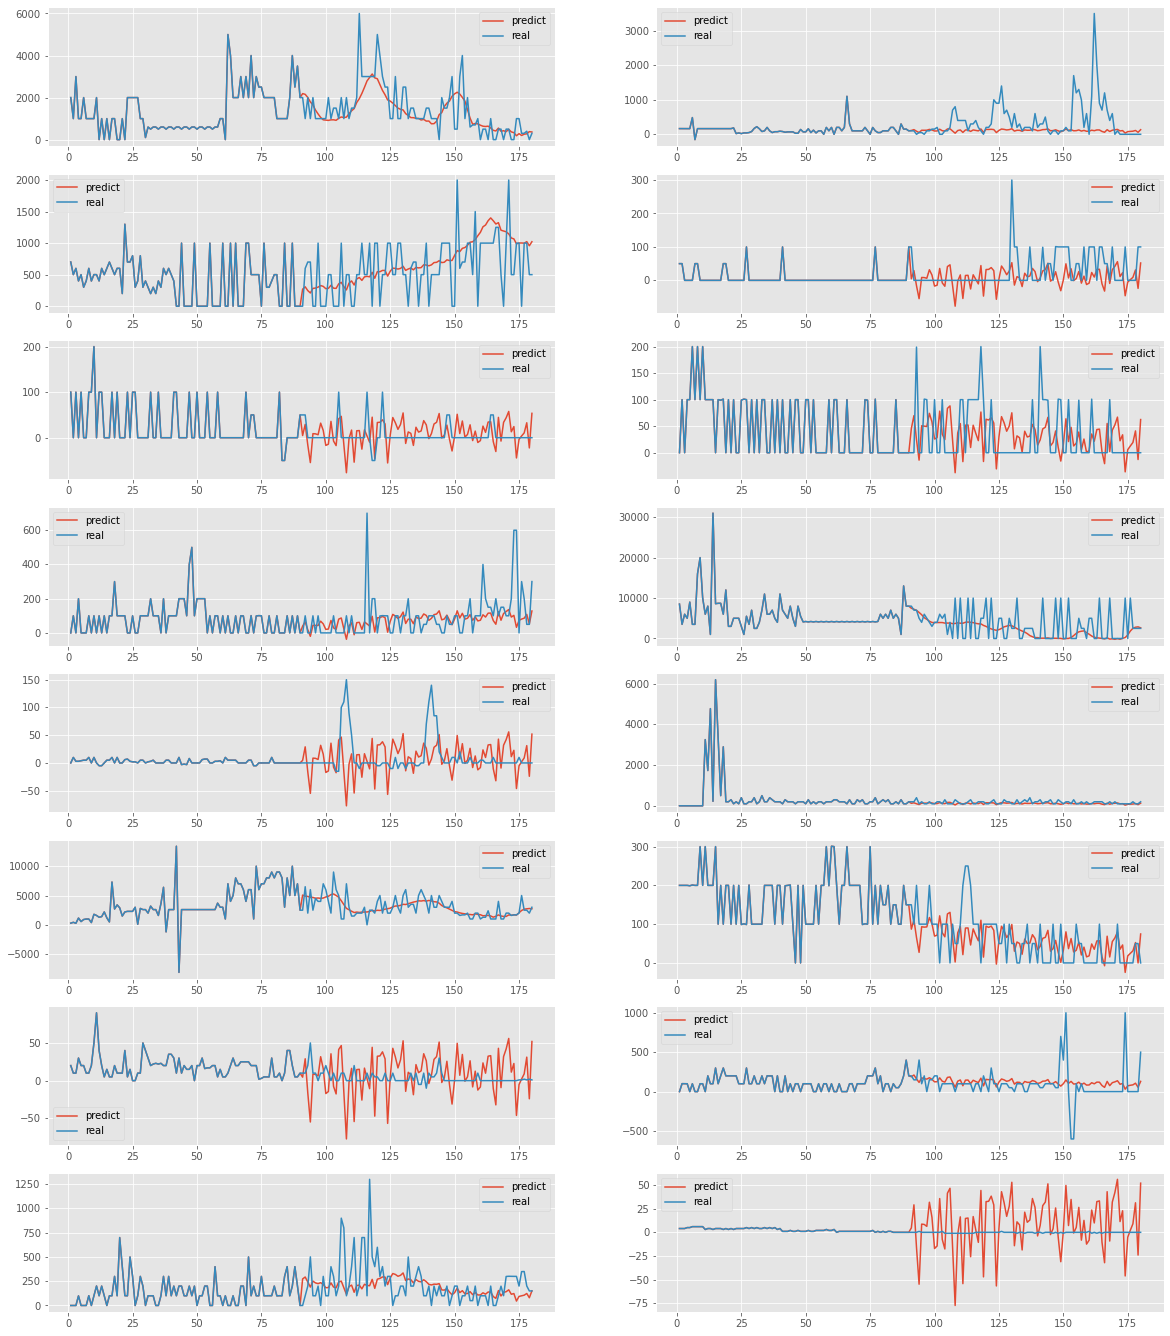

In [93]:
# rescaled_fitting

test=np.empty([16,90,17])
for i in range(90):
    test[:,i,:]=scaler_90_90.inverse_transform(X_90_90_test[32:48,i,:])
    
test_predict_temp=loaded_model6.predict(X_90_90_test[32:48])
test_predict1=scaler_y_90_90.inverse_transform(test_predict_temp[:,-1,:])
test_predict=np.concatenate([test[:,:,-2],test_predict1],axis=1)

real_target1=scaler_y_90_90.inverse_transform(y_90_90_test[32:48,-1,:])
real_target=np.concatenate([test[:,:,-2],real_target1],axis=1)

plt.figure(figsize=(20,24))
for i in range(len(real_target1)):
        plt.subplot(8,2,i+1)
        plt.plot(np.arange(1,filtersize+targetsize+1),test_predict[i,:],label='predict')
        plt.plot(np.arange(1,targetsize+filtersize+1),real_target[i],label='real')
        
        plt.legend()

ValueError: x and y must have same first dimension, but have shapes (180,) and (91,)

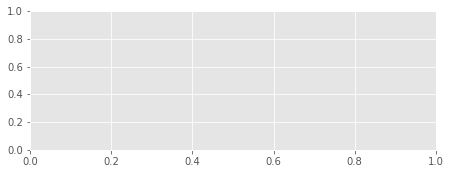

In [436]:
# rescaled_fitting
test_predict_temp=loaded_model.predict(X_90_90_test[48:64])
test_predict=np.concatenate([X_90_90_test[:16,:,-2],test_predict_temp[:,-1,:]],axis=1)
real_target1=np.concatenate([X_90_90_test[:16,:,-2],y_90_90_test[48:64,-1,:]],axis=1)
test_predict=scaler_y_90_90.inverse_transform(test_predict)
real_target1=scaler_y_90_90.inverse_transform(real_target1)
plt.figure(figsize=(16,24))
for i in range(len(real_target1)):
        plt.subplot(8,2,i+1)
        plt.plot(np.arange(1,filtersize+targetsize+1),test_predict[i,:],label='predict')
        plt.plot(np.arange(1,targetsize+filtersize+1),real_target1[i],label='real')
        
        plt.legend()

> 모델불러오기(Wavenet(180_90_1)  )

In [80]:
path7='Checkpoint/'+'Wavenet(180_90_1).h5'
loaded_model7 = tf.keras.models.load_model(path7,custom_objects={'customLoss1':last_time_step_mse},compile=False)
loaded_model7.compile(optimizer='adam', loss='mae',metrics=[last_time_step_mse])

In [81]:
loaded_model7.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_27 (Conv1D)           (None, None, 20)          700       
_________________________________________________________________
conv1d_28 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_29 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_30 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_31 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_32 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_33 (Conv1D)           (None, None, 20)         

> no scaling mae, rmse

In [373]:
predict_180_90_temp=loaded_model7.predict(X_180_90_test)
predict_180_90=predict_180_90_temp[:,-1,:] # 마지막 step의 예측값
truth_180_90=y_180_90_test[:,-1,:] # 마지막 step의 실제값

rescaled_predict_180_90=scaler_y_180_90.inverse_transform(predict_180_90) # 역스케일링
rescaled_truth_180_90=scaler_y_180_90.inverse_transform(truth_180_90) # 역스케일링


In [374]:
print('90일간의 rmse --> ',np.sqrt(np.mean(keras.metrics.mean_squared_error(rescaled_predict_180_90[:],rescaled_truth_180_90[:]))))
print('90일간의 mae --> ',np.mean(keras.metrics.mean_absolute_error(rescaled_predict_180_90[:],rescaled_truth_180_90[:])))
print('90일 뒤 하루의 rmse --> ',np.sqrt(keras.metrics.mean_squared_error(rescaled_predict_180_90[:,-1],rescaled_truth_180_90[:,-1])))
print('90일 뒤 하루의 mae --> ',np.mean((keras.metrics.mean_absolute_error(rescaled_predict_180_90[:,-1],rescaled_truth_180_90[:,-1]))))



90일간의 rmse -->  2724.739864204813
90일간의 mae -->  266.43419490800915
90일 뒤 하루의 rmse -->  2596.2564576193454
90일 뒤 하루의 mae -->  300.7789936172239


> 모델불러오기(Wavenet(180_90_1)(filter:180).h5    )  
> 모델불러오기(Wavenet(180_90_1)(filter:180).h5    )
> 모델불러오기(Wavenet(180_90_1)(filter:180).h5    )
> 모델불러오기(Wavenet(180_90_1)(filter:180).h5    )

In [95]:
path8='Checkpoint/'+'Wavenet(180_90_1)(filtersize:180).h5'
loaded_model8 = tf.keras.models.load_model(path8,custom_objects={'customLoss1':last_time_step_mse},compile=False)
loaded_model8.compile(optimizer='adam', loss='mae',metrics=[last_time_step_mse])

In [96]:
loaded_model8.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 180)         6300      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 180)         64980     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 180)         64980     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 180)         64980     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 180)         64980     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 180)         64980     
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 180)         6

> no scaling mae, rmse

In [370]:
predict_180_90_temp=loaded_model8.predict(X_180_90_test)
predict_180_90=predict_180_90_temp[:,-1,:] # 마지막 step의 예측값
truth_180_90=y_180_90_test[:,-1,:] # 마지막 step의 실제값

rescaled_predict_180_90=scaler_y_180_90.inverse_transform(predict_180_90) # 역스케일링
rescaled_truth_180_90=scaler_y_180_90.inverse_transform(truth_180_90) # 역스케일링


In [371]:
print('90일간의 rmse --> ',np.sqrt(np.mean(keras.metrics.mean_squared_error(rescaled_predict_180_90[:],rescaled_truth_180_90[:]))))
print('90일간의 mae --> ',np.mean(keras.metrics.mean_absolute_error(rescaled_predict_180_90[:],rescaled_truth_180_90[:])))
print('90일 뒤 하루의 rmse --> ',np.sqrt(keras.metrics.mean_squared_error(rescaled_predict_180_90[:,-1],rescaled_truth_180_90[:,-1])))
print('90일 뒤 하루의 mae --> ',np.mean((keras.metrics.mean_absolute_error(rescaled_predict_180_90[:,-1],rescaled_truth_180_90[:,-1]))))



90일간의 rmse -->  2634.577584810755
90일간의 mae -->  220.7385737614812
90일 뒤 하루의 rmse -->  2545.605079065854
90일 뒤 하루의 mae -->  244.03350717330676


In [98]:
targetsize=90
filtersize=180

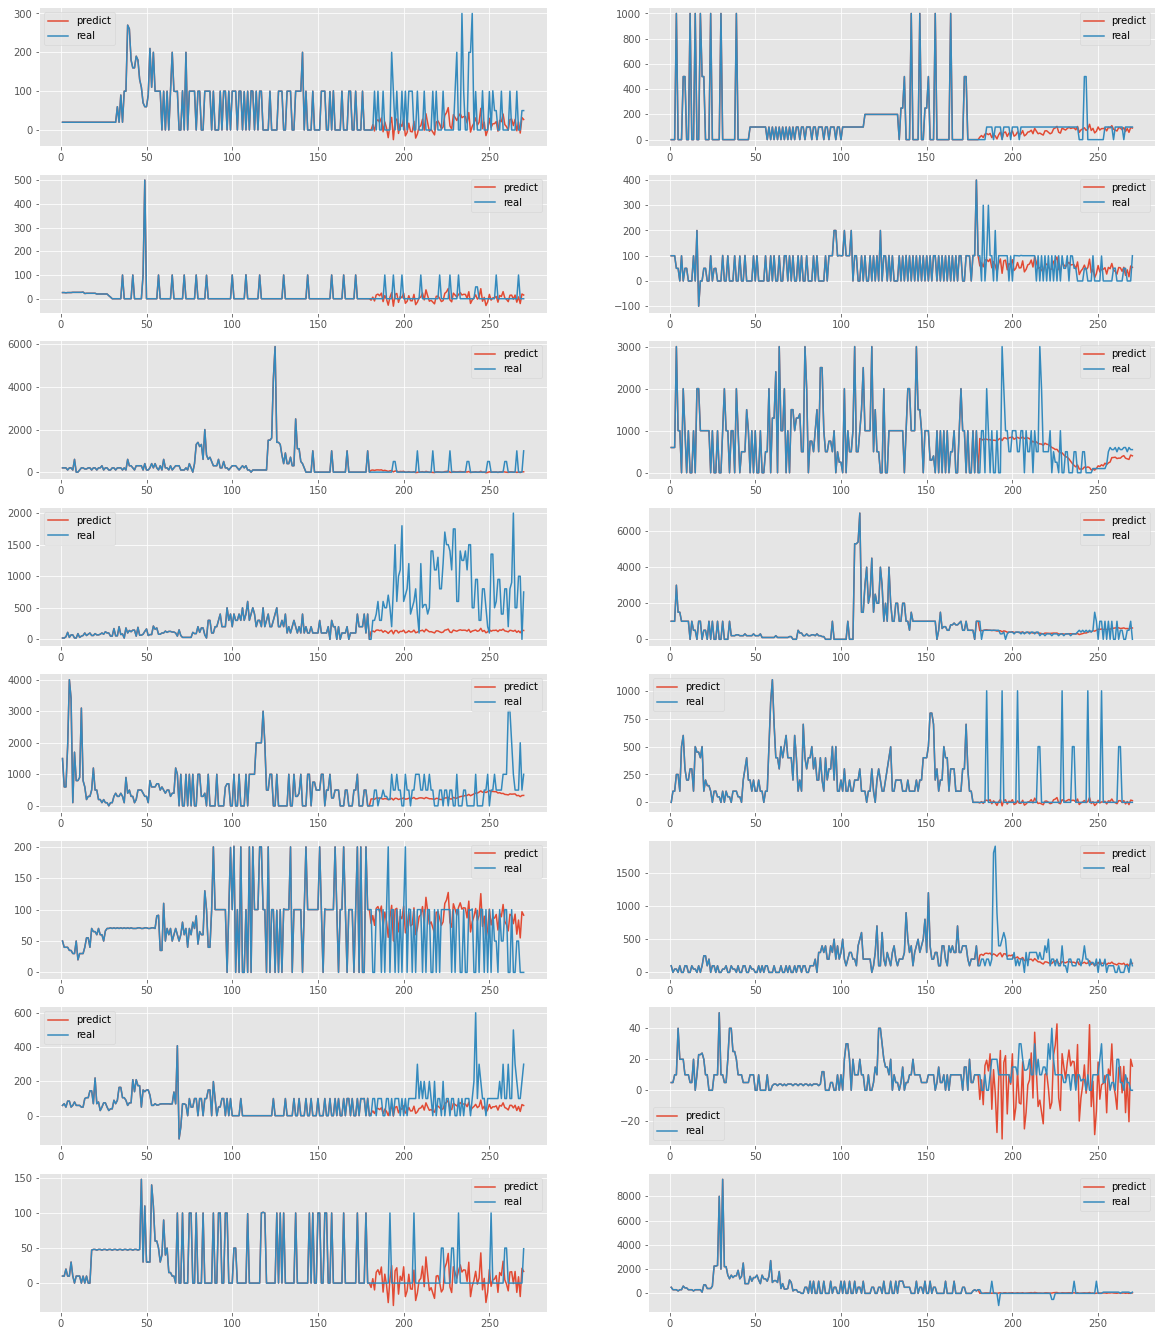

In [99]:
# rescaled_fitting

test=np.empty([16,180,17])
for i in range(180):
    test[:,i,:]=scaler_180_90.inverse_transform(X_180_90_test[64:80,i,:])
    
test_predict_temp=loaded_model8.predict(X_180_90_test[64:80])
test_predict1=scaler_y_180_90.inverse_transform(test_predict_temp[:,-1,:])
test_predict=np.concatenate([test[:,:,-2],test_predict1],axis=1)

real_target1=scaler_y_180_90.inverse_transform(y_180_90_test[64:80,-1,:])
real_target=np.concatenate([test[:,:,-2],real_target1],axis=1)

plt.figure(figsize=(20,24))
for i in range(len(real_target1)):
        plt.subplot(8,2,i+1)
        plt.plot(np.arange(1,filtersize+targetsize+1),test_predict[i,:],label='predict')
        plt.plot(np.arange(1,targetsize+filtersize+1),real_target[i],label='real')
        
        plt.legend()

> 모델불러오기(Wavenet(180_30_1).h5 )

In [257]:
path9='Checkpoint/'+'Wavenet(180_30_1).h5'
loaded_model9 = tf.keras.models.load_model(path9,custom_objects={'customLoss1':last_time_step_mse},compile=False)
loaded_model9.compile(optimizer='adam', loss='mae',metrics=[last_time_step_mse])

> no scaling mae, rmse

In [259]:
predict_180_30_temp=loaded_model9.predict(X_180_30_test)
predict_180_30=predict_180_30_temp[:,-1,:] # 마지막 step의 예측값
truth_180_30=y_180_30_test[:,-1,:] # 마지막 step의 실제값

rescaled_predict_180_30=scaler_y_180_30.inverse_transform(predict_180_30) # 역스케일링
rescaled_truth_180_30=scaler_y_180_30.inverse_transform(truth_180_30) # 역스케일링


In [260]:
print('30일간의 rmse --> ',np.sqrt(np.mean(keras.metrics.mean_squared_error(rescaled_predict_180_30[:],rescaled_truth_180_30[:]))))
print('30일간의 mae --> ',np.mean(keras.metrics.mean_absolute_error(rescaled_predict_180_30[:],rescaled_truth_180_30[:])))
print('30일 뒤 하루의 rmse --> ',np.sqrt(keras.metrics.mean_squared_error(rescaled_predict_180_30[:,-1],rescaled_truth_180_30[:,-1])))
print('30일 뒤 하루의 mae --> ',np.mean((keras.metrics.mean_absolute_error(rescaled_predict_180_30[:,-1],rescaled_truth_180_30[:,-1]))))



30일간의 rmse -->  2350.725139238303
30일간의 mae -->  234.91487627033538
30일 뒤 하루의 rmse -->  1346.6518903902845
30일 뒤 하루의 mae -->  254.9030728678951


> 모델불러오기(Wavenet(180_30_1)(filtersize:60)(plus).h5  

In [70]:
path10='Checkpoint/'+'Wavenet(180_30_1)(filtersize:60)(plus).h5'
loaded_model10 = tf.keras.models.load_model(path10,custom_objects={'customLoss1':last_time_step_mse},compile=False)
loaded_model10.compile(optimizer='adam', loss='mae',metrics=[last_time_step_mse])

> no scaling mae, rmse

In [262]:
predict_180_30_temp=loaded_model10.predict(X_180_30_test)
predict_180_30=predict_180_30_temp[:,-1,:] # 마지막 step의 예측값
truth_180_30=y_180_30_test[:,-1,:] # 마지막 step의 실제값

rescaled_predict_180_30=scaler_y_180_30.inverse_transform(predict_180_30) # 역스케일링
rescaled_truth_180_30=scaler_y_180_30.inverse_transform(truth_180_30) # 역스케일링


In [263]:
print('30일간의 rmse --> ',np.sqrt(np.mean(keras.metrics.mean_squared_error(rescaled_predict_180_30[:],rescaled_truth_180_30[:]))))
print('30일간의 mae --> ',np.mean(keras.metrics.mean_absolute_error(rescaled_predict_180_30[:],rescaled_truth_180_30[:])))
print('30일 뒤 하루의 rmse --> ',np.sqrt(keras.metrics.mean_squared_error(rescaled_predict_180_30[:,-1],rescaled_truth_180_30[:,-1])))
print('30일 뒤 하루의 mae --> ',np.mean((keras.metrics.mean_absolute_error(rescaled_predict_180_30[:,-1],rescaled_truth_180_30[:,-1]))))



30일간의 rmse -->  1985.6548309349287
30일간의 mae -->  194.13919481476614
30일 뒤 하루의 rmse -->  1183.4265496951352
30일 뒤 하루의 mae -->  204.7892221485419


> 역시 filter가 높아짐에 따라 좋지는 않았다는 사실.

In [78]:
filtersize=180

In [79]:
targetsize=30

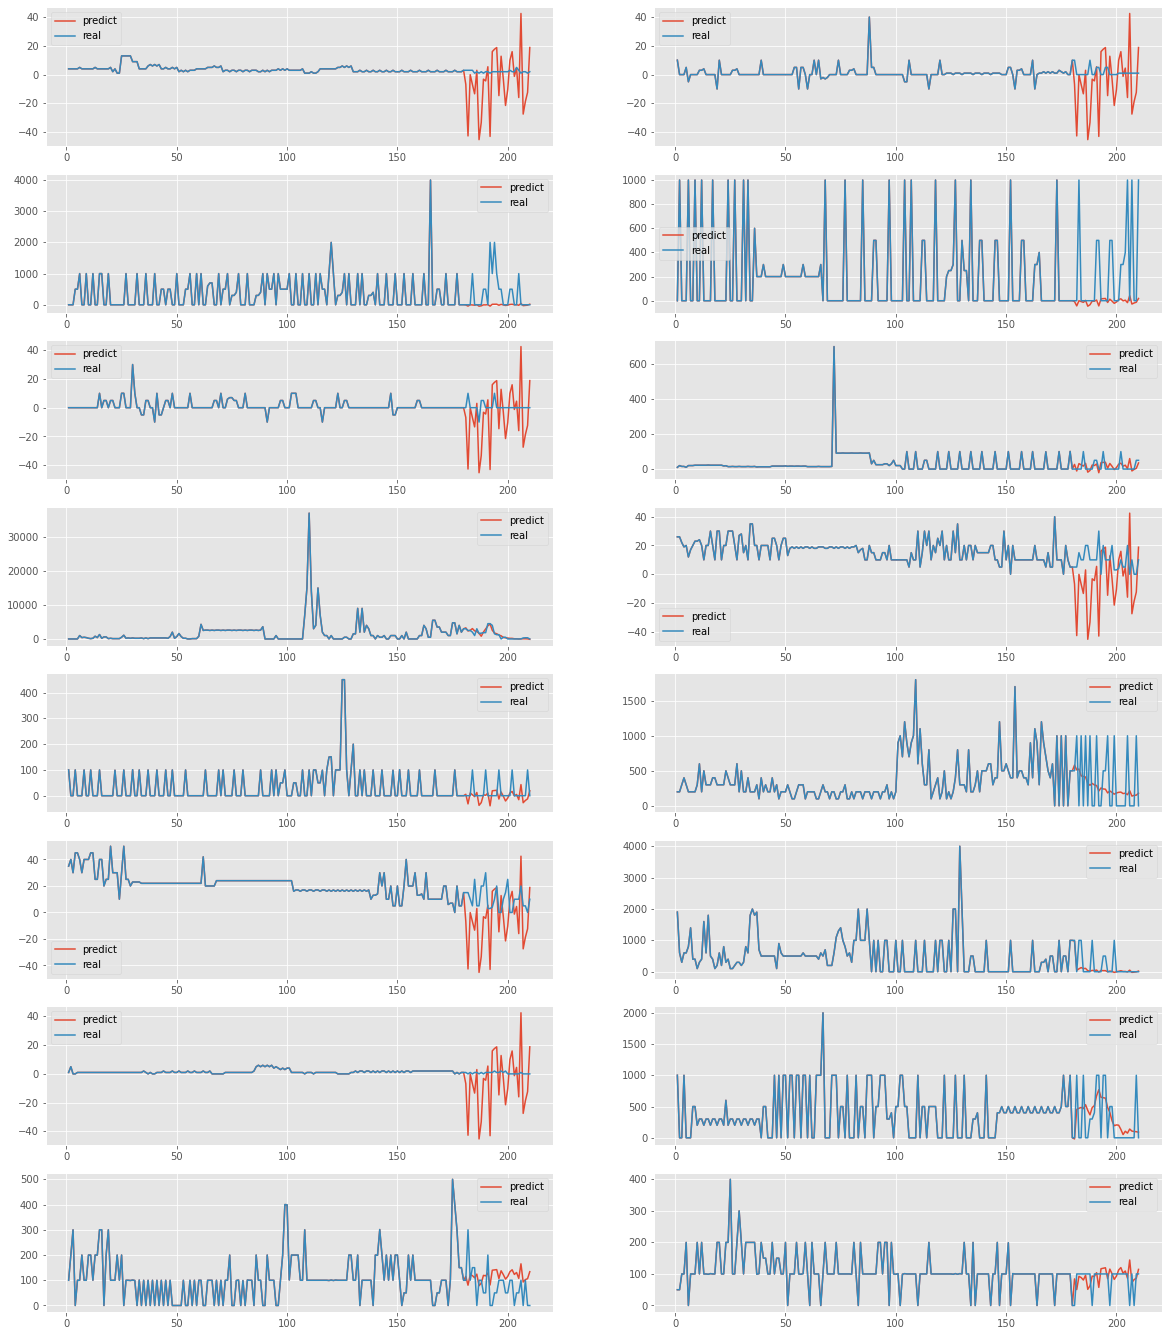

In [81]:
# rescaled_fitting

test=np.empty([16,180,17])
for i in range(180):
    test[:,i,:]=scaler_180_30.inverse_transform(X_180_30_test[32:48,i,:])
    
test_predict_temp=loaded_model10.predict(X_180_30_test[32:48])
test_predict1=scaler_y_180_30.inverse_transform(test_predict_temp[:,-1,:])
test_predict=np.concatenate([test[:,:,-2],test_predict1],axis=1)

real_target1=scaler_y_180_30.inverse_transform(y_180_30_test[32:48,-1,:])
real_target=np.concatenate([test[:,:,-2],real_target1],axis=1)

plt.figure(figsize=(20,24))
for i in range(len(real_target1)):
        plt.subplot(8,2,i+1)
        plt.plot(np.arange(1,filtersize+targetsize+1),test_predict[i,:],label='predict')
        plt.plot(np.arange(1,targetsize+filtersize+1),real_target[i],label='real')
        
        plt.legend()

> 모델불러오기 Wavenet(90_1_1).h5  

In [42]:
path11='Checkpoint/'+'Wavenet(90_1_1).h5'
loaded_model11 = tf.keras.models.load_model(path11,custom_objects={'customLoss1':last_time_step_mse},compile=False)
loaded_model11.compile(optimizer='adam', loss='mae',metrics=[last_time_step_mse])

In [85]:
predict_90_1_temp=loaded_model11.predict(X_90_1_test)
predict_90_1=predict_90_1_temp[:,-1,:] # 마지막 step의 예측값
truth_90_1=y_90_1_test[:,-1,:] # 마지막 step의 실제값

rescaled_predict_90_1=scaler_y_90_1.inverse_transform(predict_90_1) # 역스케일링
rescaled_truth_90_1=scaler_y_90_1.inverse_transform(truth_90_1) # 역스케일링


In [86]:
keras.metrics.mean_absolute_error(rescaled_predict_90_1[:],rescaled_truth_90_1[:])

<tf.Tensor: shape=(38085,), dtype=float64, numpy=
array([62.73167419,  2.8584764 ,  1.54714727, ..., 46.31811523,
       57.75146484, 42.36626053])>

In [87]:
print('1일간의 rmse --> ',np.sqrt(np.mean(keras.metrics.mean_squared_error(rescaled_predict_90_1[:],rescaled_truth_90_1[:]))))
print('1일간의 mae --> ',np.mean(keras.metrics.mean_absolute_error(rescaled_predict_90_1[:],rescaled_truth_90_1[:])))
print('1일 뒤 하루의 rmse --> ',np.sqrt(keras.metrics.mean_squared_error(rescaled_predict_90_1[:,-1],rescaled_truth_90_1[:,-1])))
print('1일 뒤 하루의 mae --> ',np.mean((keras.metrics.mean_absolute_error(rescaled_predict_90_1[:,-1],rescaled_truth_90_1[:,-1]))))



1일간의 rmse -->  35.093644815759724
1일간의 mae -->  14.592871920668728
1일 뒤 하루의 rmse -->  35.09364481575973
1일 뒤 하루의 mae -->  14.592871920668728


In [131]:
print('실제 값 : ', [ "{:0.2f}".format(x) for x in scaler_y_90_1.inverse_transform(y_90_1_test[:15,-1]).flatten() ])
print('예측 값 : ',[ "{:0.2f}".format(x) for x in scaler_y_90_1.inverse_transform(loaded_model11.predict(X_90_1_test[:15].reshape(15,90,17))[:,-1]).flatten()])

실제 값 :  ['200.00', '0.00', '2.00', '100.00', '2500.00', '1.00', '0.00', '0.00', '0.00', '400.00', '20.00', '0.00', '50.00', '1750.00', '-100.00']
예측 값 :  ['137.27', '2.86', '3.55', '84.98', '2549.46', '4.39', '-6.19', '4.90', '-4.45', '385.07', '-1.31', '91.83', '43.25', '1751.10', '-9.07']


In [128]:
print('예측 값 : ',[ "{:0.3f}".format(x) for x in scaler_y_90_1.inverse_transform(loaded_model11.predict(X_90_1_test[:15].reshape(15,90,17))[:,-1]).flatten()])

ValueError: cannot reshape array of size 30600 into shape (15,90,17)

In [118]:
scaler_y_90_1.inverse_transform(y_90_1_test[:10,-1]).flatten()

array([2.0e+02, 0.0e+00, 2.0e+00, 1.0e+02, 2.5e+03, 1.0e+00, 0.0e+00,
       0.0e+00, 0.0e+00, 4.0e+02])

In [113]:
scaler_y_90_1.inverse_transform(loaded_model11.predict(X_90_1_test[:10].reshape(10,90,17))[:,-1]).flatten()

array([ 137.26833  ,    2.8584764,    3.5471473,   84.975555 ,
       2549.456    ,    4.389498 ,   -6.1947737,    4.902535 ,
         -4.4499865,  385.06738  ], dtype=float32)

In [101]:
print('예측값 :  ', scaler_y_90_1.inverse_transform(loaded_model11.predict(X_90_1_test[:10].reshape(10,90,17))[:,-1]).flatten())
print('실제값 : ', scaler_y_90_1.inverse_transform(y_90_1_test[:10,-1]).flatten())

예측값 :   [ 137.26833      2.8584764    3.5471473   84.975555  2549.456
    4.389498    -6.1947737    4.902535    -4.4499865  385.06738  ]
실제값 :  [2.0e+02 0.0e+00 2.0e+00 1.0e+02 2.5e+03 1.0e+00 0.0e+00 0.0e+00 0.0e+00
 4.0e+02]


In [283]:
y_90_1_test.shape

(38085, 90, 1)

> 모델이다.

In [48]:
data_90_1=loader.get_data(90,1,1,['channel'])

In [53]:
channel_boolean=data_90_1[0].iloc[:,0].index==0
channel_location=np.where(data_90_1[0].iloc[:,0].index==0)[0]
channel_name=data_90_1[0].iloc[:,0][channel_boolean].values

In [56]:
targetsize=1


In [57]:
def preprocess_for_score2(X,y,target_size):
    
    X_train_3d=stack_to_multi(X)
    X_train_scaled,scaler=fit_3d2(X_train_3d)#scaler도 받자.
    X_train_subdiff=X['sub_diff']
    
    # (샘플개수 , (180+30)의 TARGET
    temp1=pd.concat([X_train_subdiff,y],axis=1)
    # (샘플, timestep, targetsize)
    y_train_3d=np.empty((X_train_subdiff.shape[0],X_train_subdiff.shape[1],target_size)) # 30 : targetsizeb

    for t in range(X_train_subdiff.shape[1]): # 180 Timestep
        y_train_3d[:,t]=temp1.iloc[:,t:t+target_size]

    y_train_temp=y_train_3d.reshape(-1,1)
    scaler_y=MinMaxScaler()
    y_train_scaled=scaler_y.fit_transform(y_train_temp)
    y_train_scaled=y_train_scaled.reshape(y_train_3d.shape[0],y_train_3d.shape[1],y_train_3d.shape[2])

    
    return X_train_scaled,y_train_scaled,scaler,scaler_y


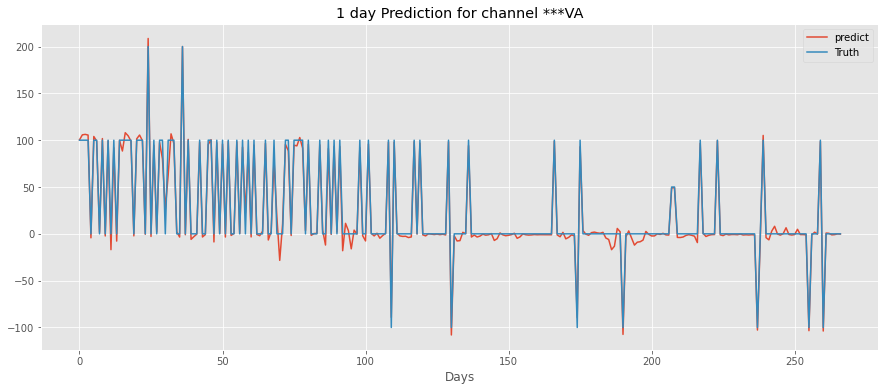

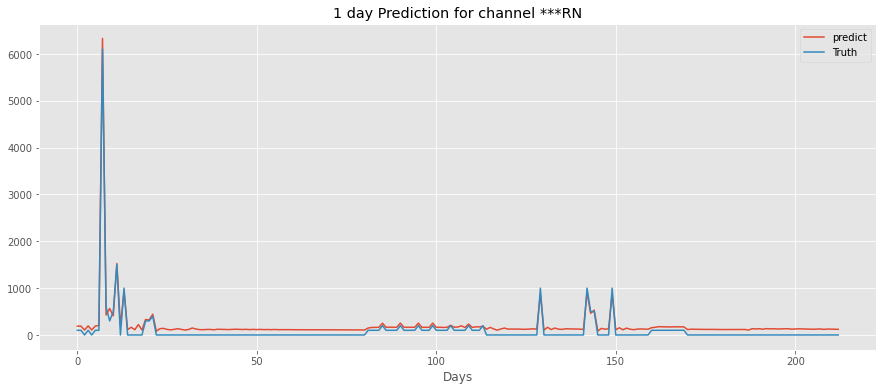

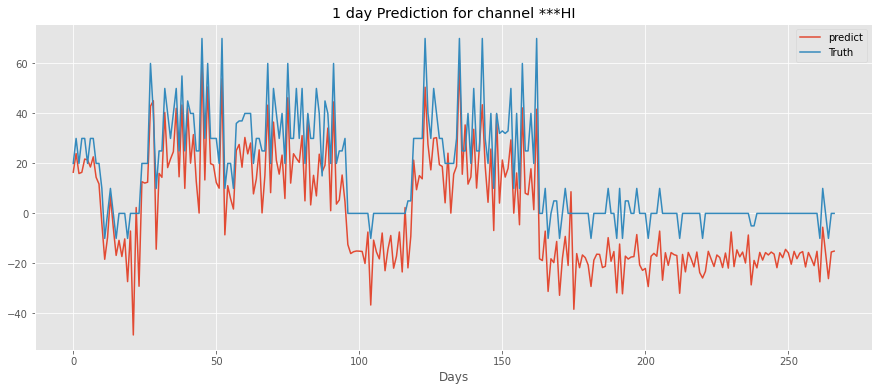

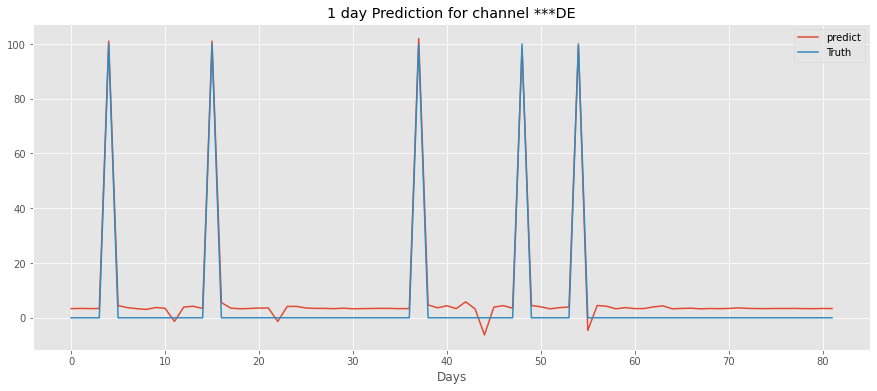

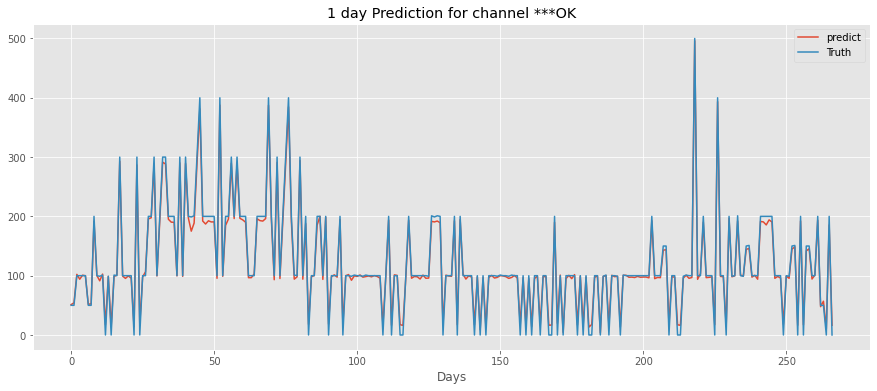

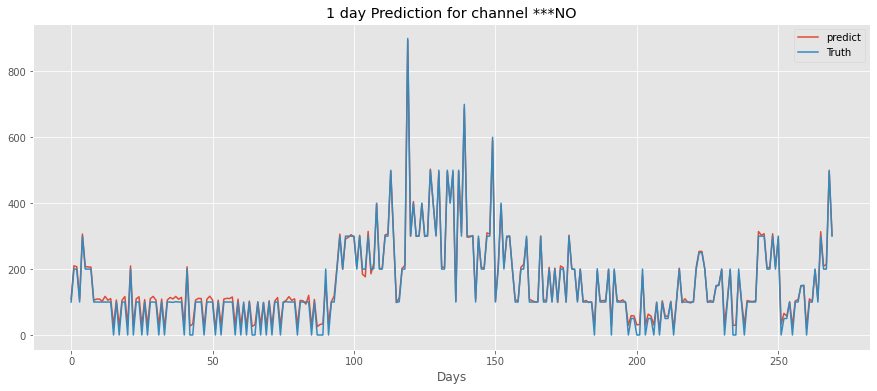

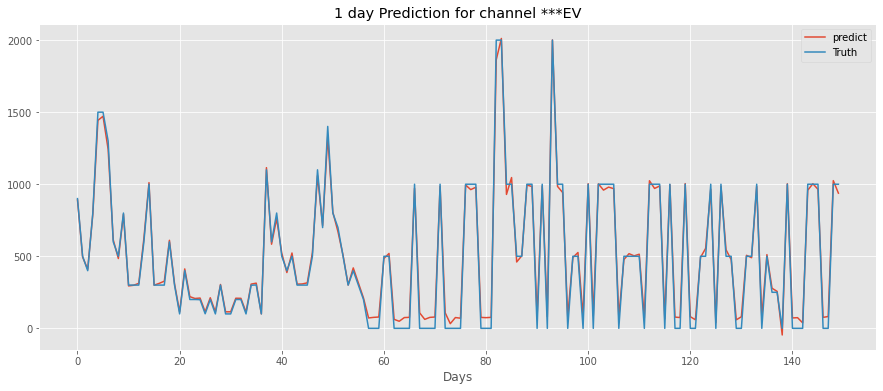

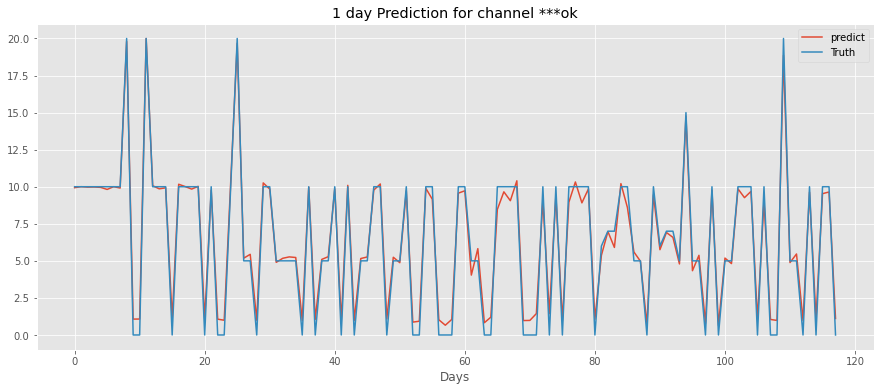

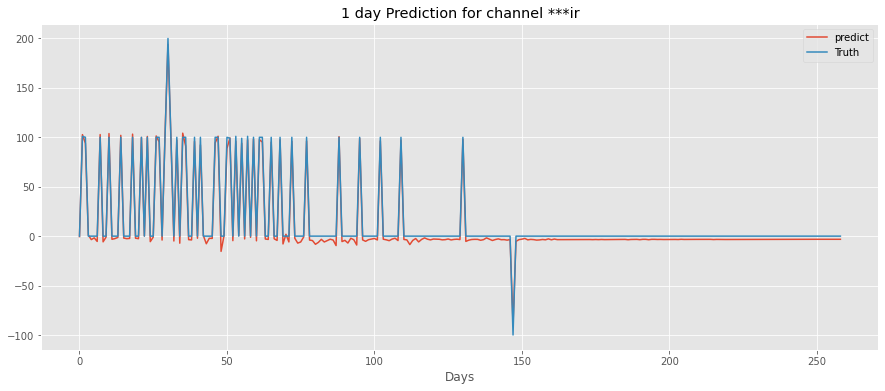

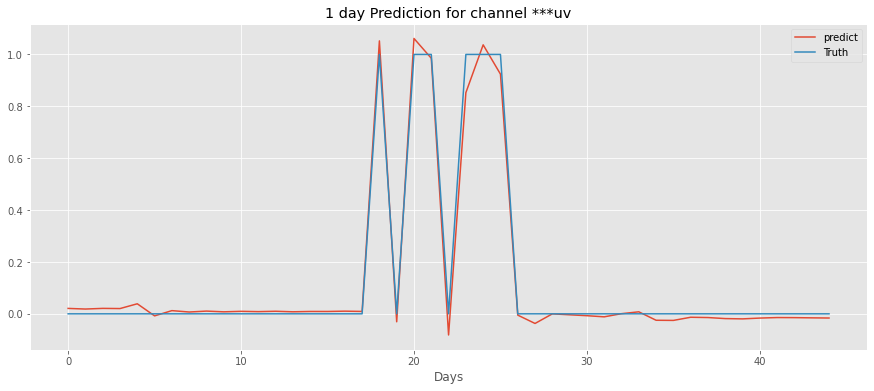

In [65]:
for i in range(15,25):
    X2,y2,scaler_X2,scaler_y2=preprocess_for_score2(X_90_1.iloc[channel_location[i]:channel_location[i+1]], y_90_1.iloc[channel_location[i]:channel_location[i+1]], targetsize)# 데이터는 get_loaded 한경우
    plt.figure(figsize=(15,6))

    plt.plot(scaler_y2.inverse_transform(loaded_model11.predict(X2)[:,-1].reshape(1,-1)).flatten(), label='predict') # 91일 ~ 끝까지. 
    plt.plot(scaler_y2.inverse_transform(y2[:,-1].reshape(1,-1)).flatten(), label='Truth')

    plt.legend()

    plt.title('1 day Prediction for channel ***'+'{}'.format(channel_name[i])[-2:])
    plt.xlabel('Days')

In [ ]:
#data=loader.get_data(90,1,1, ['channel'])

In [239]:
data[0][243:511]

channel                    channel  \
0    123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese   
1    123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese   
2    123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese   
3    123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese   
4    123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese   
..                         ...                        ...   
263  123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese   
264  123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese   
265  123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese   
266  123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese   
267  123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese   

                       channel                    channel  \
0    123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese   
1    123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese   
2    123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese   
3    123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese   
4    123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese   
..                         ...                        ...   
263  123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese   
264  123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese   
265  123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese   
266  123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese   
267  123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese   

                       channel                    channel  \
0    123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese   
1    123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese   
2    123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese   
3    123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese   
4    123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese   
..                         ...                        ...   
263  123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese   
264  123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese   
265  123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese   
266  123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese   
267  123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese   

                       channel                    channel  \
0    123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese   
1    123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese   
2    123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese   
3    123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese   
4    123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese   
..                         ...                        ...   
263  123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese   
264  123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese   
265  123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese   
266  123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese   
267  123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese   

                       channel                    channel  ...  \
0    123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese  ...   
1    123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese  ...   
2    123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese  ...   
3    123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese  ...   
4    123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese  ...   
..                         ...                        ...  ...   
263  123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese  ...   
264  123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese  ...   
265  123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese  ...   
266  123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese  ...   
267  123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese  ...   

                       channel                    channel  \
0    123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese   
1    123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese   
2    123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chinese   
3    123 GO! CHALLENGE Chinese  123 GO! CHALLENGE Chin

> 1~243

> 단일 스케일링

In [197]:
X2,y2,scaler_X2,scaler_y2=preprocess_for_score2(X_90_1.head(243), y_90_1.head(243), 1) # 데이터는 get_loaded 한경우

(243, 90)


In [199]:
X2.shape

(243, 90, 17)

In [206]:
X_90_1_test[:10].shape

(10, 90, 17)

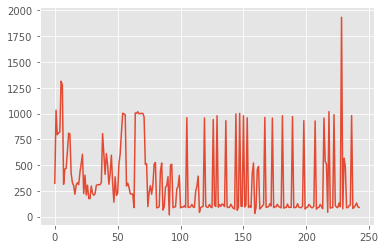

In [212]:
plt.plot(scaler_y2.inverse_transform(loaded_model11.predict(X2)[:,-1]).flatten())

In [213]:
y2.shape

(243, 90, 1)

In [220]:
X2.shape

(243, 90, 17)

In [221]:
loaded_model11.predict(X2).shape

(243, 90, 1)

Text(0.5, 0, 'Days')

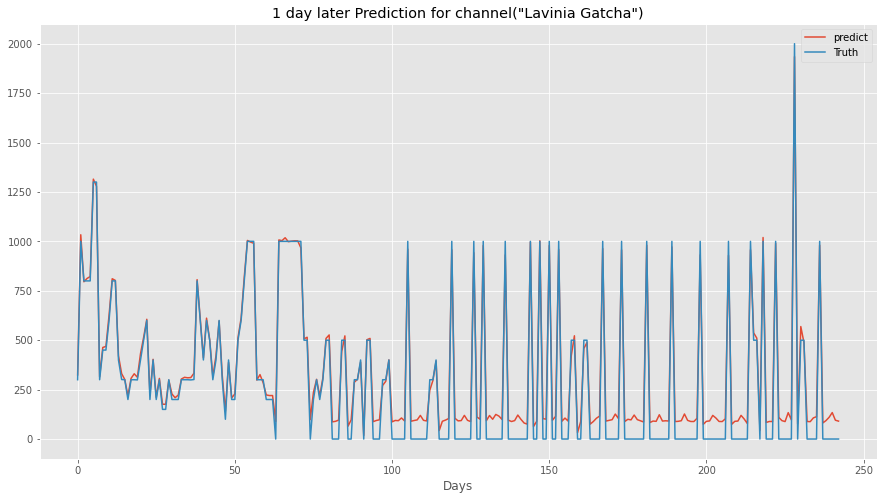

In [228]:
plt.figure(figsize=(15,8))
plt.plot(scaler_y2.inverse_transform(loaded_model11.predict(X2)[:,-1]).flatten(), label='predict') # 91일 ~ 끝까지. 
plt.plot(scaler_y2.inverse_transform(y2[:,-1]), label='Truth')
plt.legend()

plt.title('1 day later Prediction for channel("Lavinia Gatcha")')
plt.xlabel('Days')

> 2번째 채널. (243~511)

In [264]:
data[0][2203:2453]

channel   channel   channel   channel   channel   channel   channel  \
0    AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY   
1    AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY   
2    AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY   
3    AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY   
4    AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY   
..        ...       ...       ...       ...       ...       ...       ...   
245  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY   
246  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY   
247  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY   
248  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY   
249  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY   

      channel   channel   channel  ...   channel   channel   channel  \
0    AMY99AMY  AMY99AMY  AMY99AMY  ...  AMY99AMY  AMY99AMY  AMY99AMY   
1    AMY99AMY  AMY99AMY  AMY99AMY  ...  AMY99AMY  AMY99AMY  AMY99AMY   
2    AMY99AMY  AMY99AMY  AMY99AMY  ...  AMY99AMY  AMY99AMY  AMY99AMY   
3    AMY99AMY  AMY99AMY  AMY99AMY  ...  AMY99AMY  AMY99AMY  AMY99AMY   
4    AMY99AMY  AMY99AMY  AMY99AMY  ...  AMY99AMY  AMY99AMY  AMY99AMY   
..        ...       ...       ...  ...       ...       ...       ...   
245  AMY99AMY  AMY99AMY  AMY99AMY  ...  AMY99AMY  AMY99AMY  AMY99AMY   
246  AMY99AMY  AMY99AMY  AMY99AMY  ...  AMY99AMY  AMY99AMY  AMY99AMY   
247  AMY99AMY  AMY99AMY  AMY99AMY  ...  AMY99AMY  AMY99AMY  AMY99AMY   
248  AMY99AMY  AMY99AMY  AMY99AMY  ...  AMY99AMY  AMY99AMY  AMY99AMY   
249  AMY99AMY  AMY99AMY  AMY99AMY  ...  AMY99AMY  AMY99AMY  AMY99AMY   

      channel   channel   channel   channel   channel   channel   channel  
0    AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  
1    AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  
2    AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  
3    AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  
4    AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  
..        ...       ...       ...       ...       ...       ...       ...  
245  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  
246  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  
247  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  
248  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  
249  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  AMY99AMY  

[250 rows x 90 columns]

In [240]:
X2,y2,scaler_X2,scaler_y2=preprocess_for_score2(X_90_1[243:511], y_90_1[243:511], 1) # 데이터는 get_loaded 한경우

(268, 90)


Text(0.5, 0, 'Days')

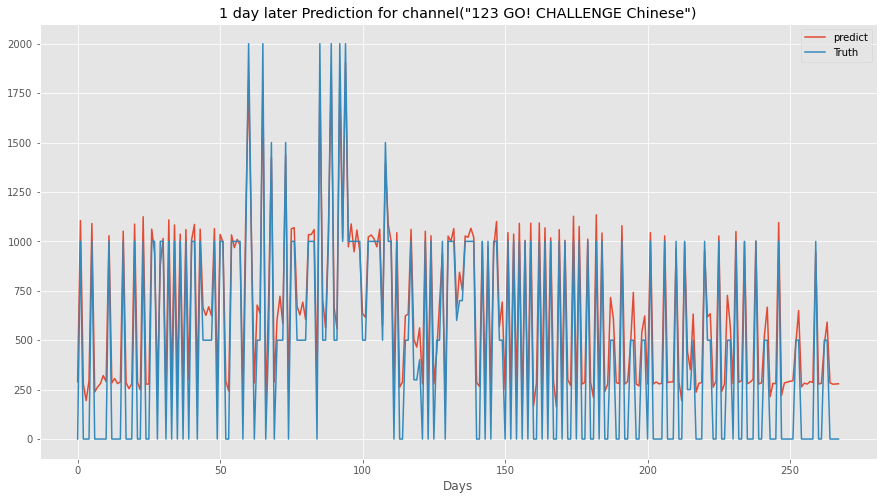

In [246]:
plt.figure(figsize=(15,8))
plt.plot(scaler_y2.inverse_transform(loaded_model11.predict(X2)[:,-1]).flatten(), label='predict') # 91일 ~ 끝까지. 
plt.plot(scaler_y2.inverse_transform(y2[:,-1]), label='Truth')
plt.legend()

plt.title('1 day later Prediction for channel("123 GO! CHALLENGE Chinese")')
plt.xlabel('Days')

> 3번째 채널 [1875:2120]

Text(0.5, 0, 'Days')

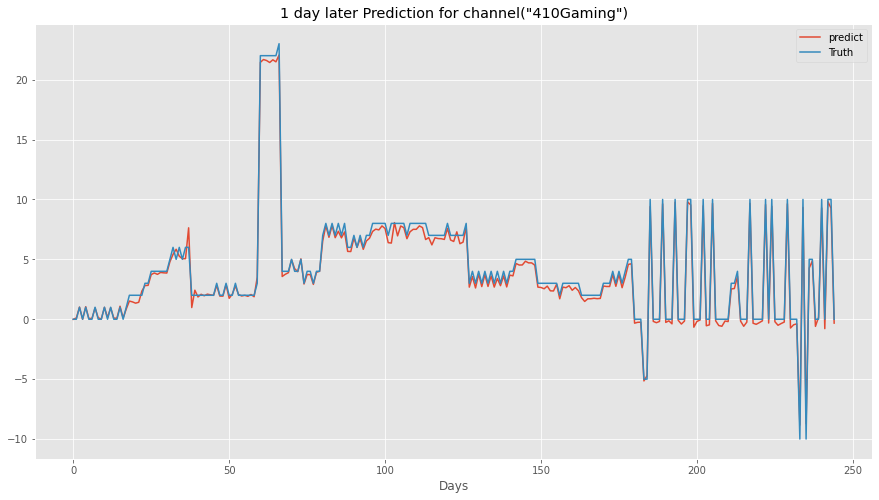

In [267]:
X2,y2,scaler_X2,scaler_y2=preprocess_for_score2(X_90_1[1875:2120], y_90_1[1875:2120], 1) # 데이터는 get_loaded 한경우
plt.figure(figsize=(15,8))
plt.plot(scaler_y2.inverse_transform(loaded_model11.predict(X2)[:,-1]).flatten(), label='predict') # 91일 ~ 끝까지. 
plt.plot(scaler_y2.inverse_transform(y2[:,-1]), label='Truth')
plt.legend()

plt.title('1 day later Prediction for channel("410Gaming")')
plt.xlabel('Days')

>4번째 채널 2203:2453

(250, 90)


Text(0.5, 0, 'Days')

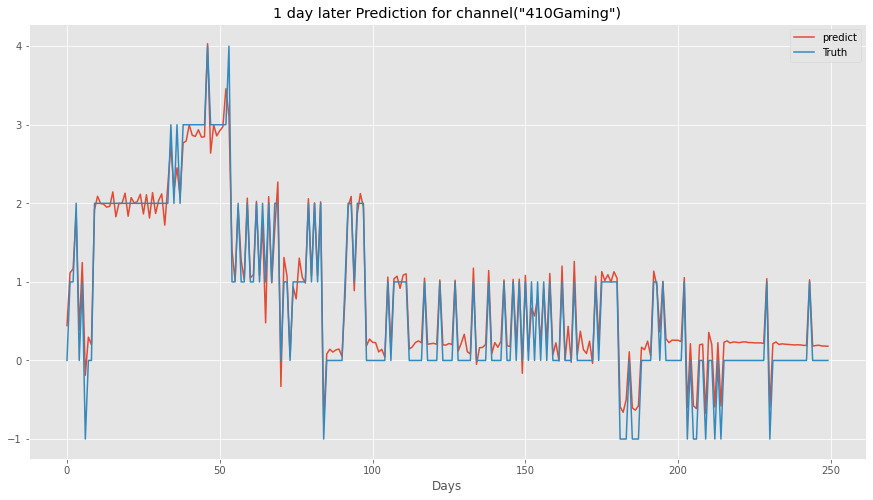

In [268]:
X2,y2,scaler_X2,scaler_y2=preprocess_for_score2(X_90_1[2203:2453], y_90_1[2203:2453], 1) # 데이터는 get_loaded 한경우
plt.figure(figsize=(15,8))
plt.plot(scaler_y2.inverse_transform(loaded_model11.predict(X2)[:,-1]).flatten(), label='predict') # 91일 ~ 끝까지. 
plt.plot(scaler_y2.inverse_transform(y2[:,-1]), label='Truth')
plt.legend()

plt.title('1 day later Prediction for channel("410Gaming")')
plt.xlabel('Days')

In [ ]:
2203:2453

(1000, 90)


Text(0.5, 0, 'Days')

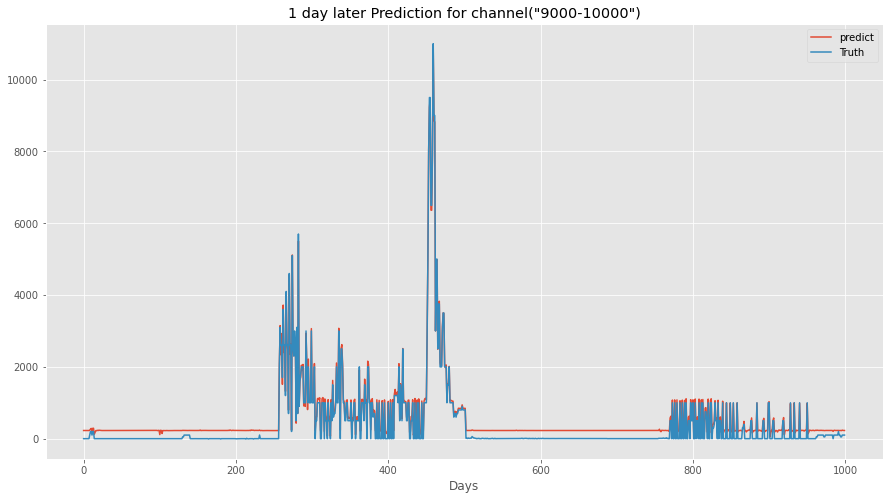

In [289]:
X2,y2,scaler_X2,scaler_y2=preprocess_for_score2(X_90_1[8000:9000], y_90_1[8000:9000], 1) # 데이터는 get_loaded 한경우
plt.figure(figsize=(15,8))
plt.plot(scaler_y2.inverse_transform(loaded_model11.predict(X2)[:,-1]).flatten(), label='predict') # 91일 ~ 끝까지. 
plt.plot(scaler_y2.inverse_transform(y2[:,-1]), label='Truth')
plt.legend()

plt.title('1 day later Prediction for channel("9000-10000")')
plt.xlabel('Days')

In [ ]:
AMY99AMY

>plotting

> 무작위

In [282]:
data[0].iloc[5823:6090]

channel     channel     channel     channel     channel     channel  \
0    Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye   
1    Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye   
2    Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye   
3    Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye   
4    Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye   
..          ...         ...         ...         ...         ...         ...   
262  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye   
263  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye   
264  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye   
265  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye   
266  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye   

        channel     channel     channel     channel  ...     channel  \
0    Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  ...  Ali Bumaye   
1    Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  ...  Ali Bumaye   
2    Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  ...  Ali Bumaye   
3    Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  ...  Ali Bumaye   
4    Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  ...  Ali Bumaye   
..          ...         ...         ...         ...  ...         ...   
262  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  ...  Ali Bumaye   
263  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  ...  Ali Bumaye   
264  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  ...  Ali Bumaye   
265  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  ...  Ali Bumaye   
266  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  ...  Ali Bumaye   

        channel     channel     channel     channel     channel     channel  \
0    Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye   
1    Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye   
2    Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye   
3    Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye   
4    Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye   
..          ...         ...         ...         ...         ...         ...   
262  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye   
263  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye   
264  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye   
265  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye   
266  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye  Ali Bumaye   

        channel     channel     channel  
0    Ali Bumaye  Ali Bumaye  Ali Bumaye  
1    Ali Bumaye  Ali Bumaye  Ali Bumaye  
2    Ali Bumaye  Ali Bumaye  Ali Bumaye  
3    Ali Bumaye  Ali Bumaye  Ali Bumaye  
4    Ali Bumaye  Ali Bumaye  Ali Bumaye  
..          ...         ...         ...  
262  Ali Bumaye  Ali Bumaye  Ali Bumaye  
263  Ali Bumaye  Ali Bumaye  Ali Bumaye  
264  Ali Bumaye  Ali Bumaye  Ali Bumaye  
265  Ali Bumaye  Ali Bumaye  Ali Bumaye  
266  Ali Bumaye  Ali Bumaye  Ali Bumaye  

[267 rows x 90 columns]

(267, 90)


Text(0.5, 0, 'Days')

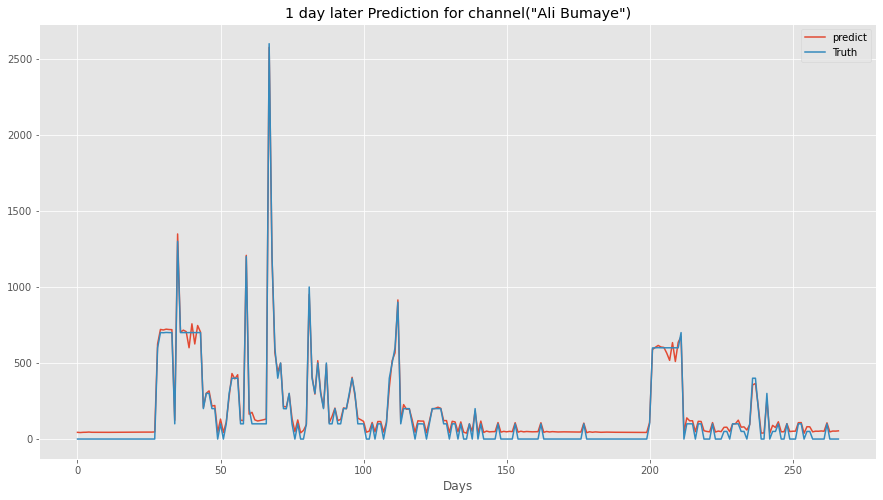

In [284]:
X2,y2,scaler_X2,scaler_y2=preprocess_for_score2(X_90_1[5823:6090], y_90_1[5823:6090], 1) # 데이터는 get_loaded 한경우
plt.figure(figsize=(15,8))
plt.plot(scaler_y2.inverse_transform(loaded_model11.predict(X2)[:,-1]).flatten(), label='predict') # 91일 ~ 끝까지. 
plt.plot(scaler_y2.inverse_transform(y2[:,-1]), label='Truth')
plt.legend()

plt.title('1 day later Prediction for channel("Ali Bumaye")')
plt.xlabel('Days')

In [284]:
filtersize=90
targetsize=1

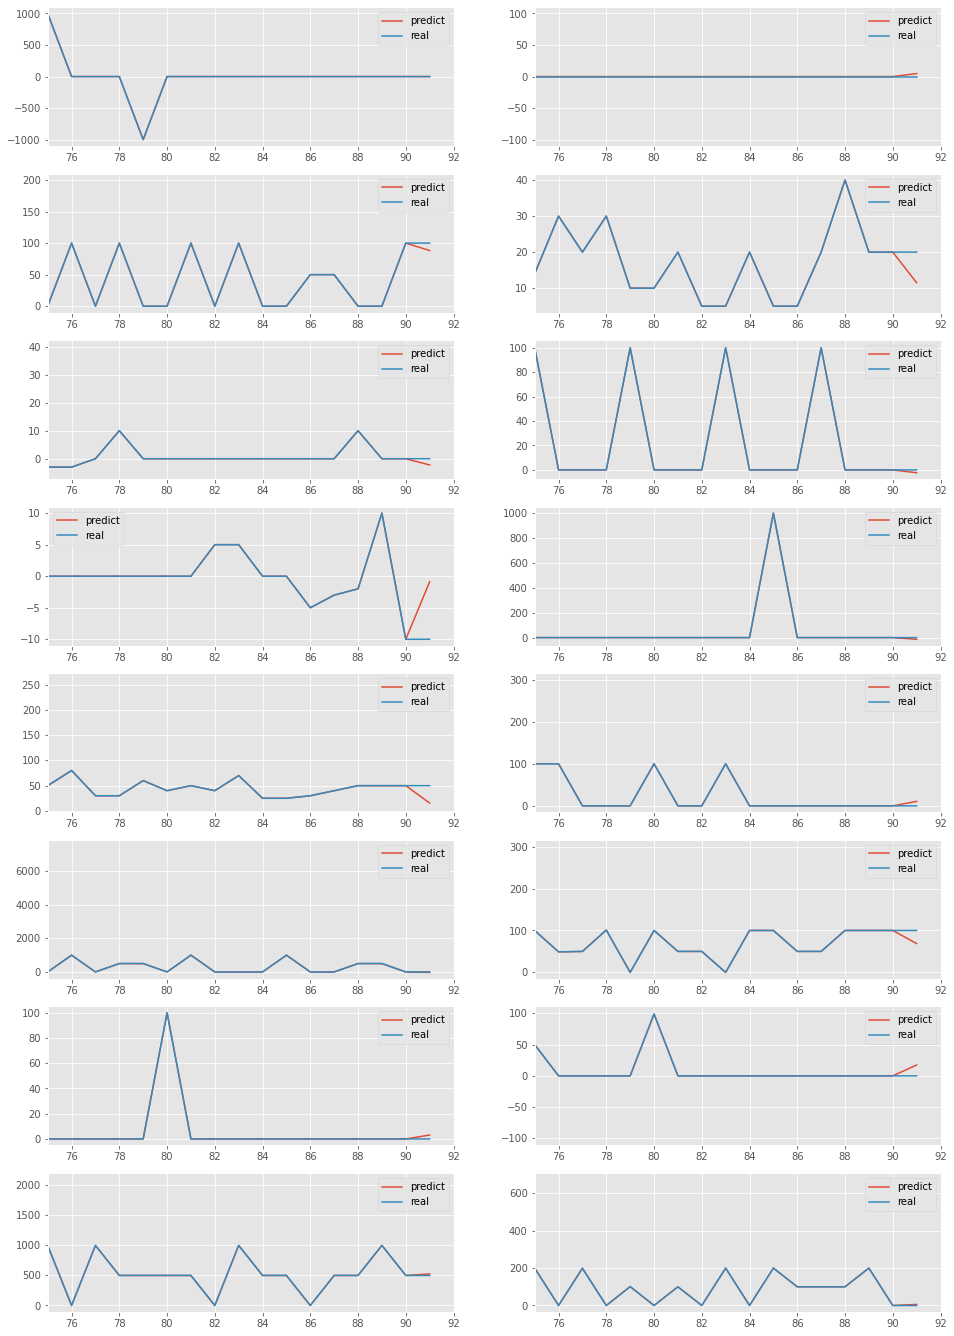

In [483]:
# rescaled_fitting
test=np.empty([16,90,17])

for i in range(90):
    test[:,i,:]=scaler_90_1.inverse_transform(X_90_1_test[160:176,i,:])
    
test_predict_temp=loaded_model11.predict(X_90_1_test[160:176])
test_predict1=scaler_y_90_1.inverse_transform(test_predict_temp[:,-1,:])
test_predict=np.concatenate([test[:,:,-2],test_predict1],axis=1)

real_target1=scaler_y_90_1.inverse_transform(y_90_1_test[160:176,-1,:])
real_target=np.concatenate([test[:,:,-2],real_target1],axis=1)

plt.figure(figsize=(16,24))
for i in range(len(real_target1)):
        plt.subplot(8,2,i+1)
        plt.plot(np.arange(1,filtersize+targetsize+1),test_predict[i,:],label='predict')
        plt.plot(np.arange(1,targetsize+filtersize+1),real_target[i],label='real')
        plt.xlim([75,92])
        plt.legend()

> 모델불러오기 Wavenet(180_1_1).h5

In [66]:
path12='Checkpoint/'+'Wavenet(180_1_1).h5'
loaded_model12 = tf.keras.models.load_model(path12,custom_objects={'customLoss1':last_time_step_mse},compile=False)
loaded_model12.compile(optimizer='adam', loss='mae',metrics=[last_time_step_mse])

> no scaling mae, rmse

In [272]:
predict_180_1_temp=loaded_model12.predict(X_180_1_test)
predict_180_1=predict_180_1_temp[:,-1,:] # 마지막 step의 예측값
truth_180_1=y_180_1_test[:,-1,:] # 마지막 step의 실제값

rescaled_predict_180_1=scaler_y_180_1.inverse_transform(predict_180_1) # 역스케일링
rescaled_truth_180_1=scaler_y_180_1.inverse_transform(truth_180_1) # 역스케일링


In [273]:
print('1일간의 rmse --> ',np.sqrt(np.mean(keras.metrics.mean_squared_error(rescaled_predict_180_1[:],rescaled_truth_180_1[:]))))
print('1일간의 mae --> ',np.mean(keras.metrics.mean_absolute_error(rescaled_predict_180_1[:],rescaled_truth_180_1[:])))
print('1일 뒤 하루의 rmse --> ',np.sqrt(keras.metrics.mean_squared_error(rescaled_predict_180_1[:,-1],rescaled_truth_180_1[:,-1])))
print('1일 뒤 하루의 mae --> ',np.mean((keras.metrics.mean_absolute_error(rescaled_predict_180_1[:,-1],rescaled_truth_180_1[:,-1]))))



1일간의 rmse -->  51.49077456996458
1일간의 mae -->  24.60217405973018
1일 뒤 하루의 rmse -->  51.49077456996457
1일 뒤 하루의 mae -->  24.602174059730174


In [ ]:
channel_boolean=data_180_1[0].iloc[:,0].index==0
channel_location=np.where(data_180_1[0].iloc[:,0].index==0)[0]
channel_name=data_180_1[0].iloc[:,0][channel_boolean].values

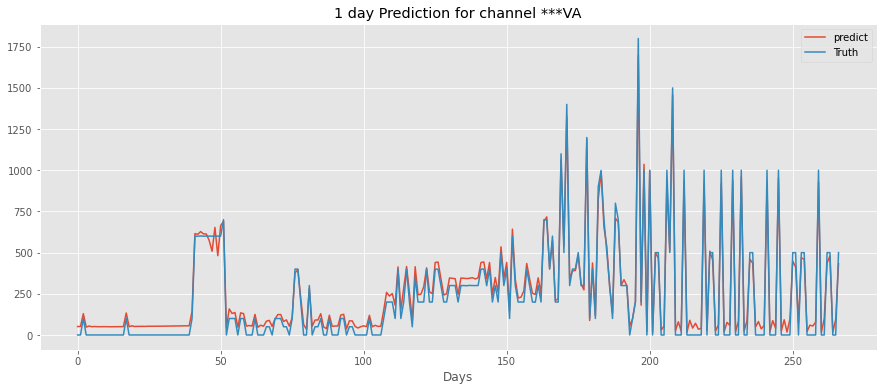

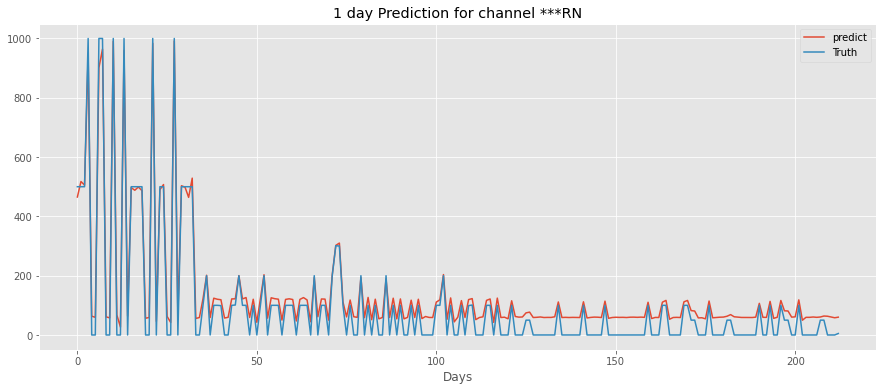

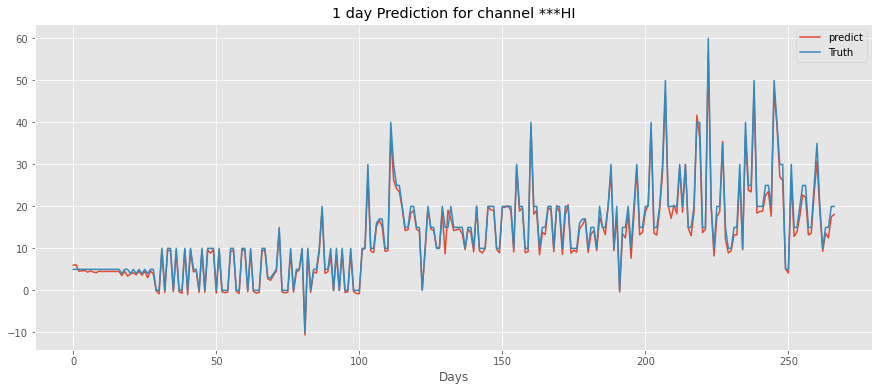

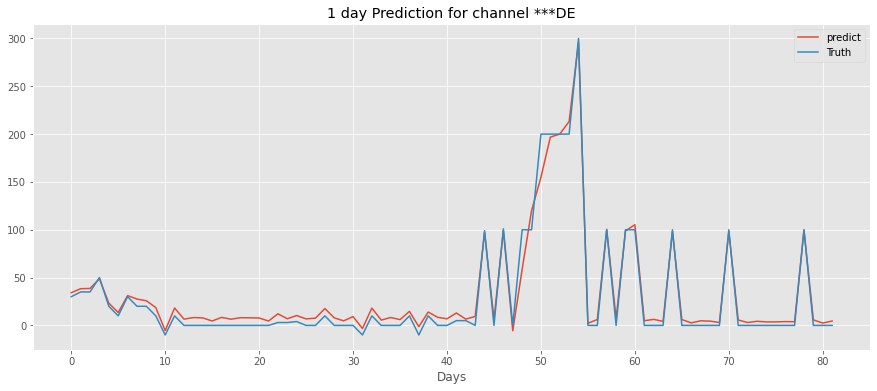

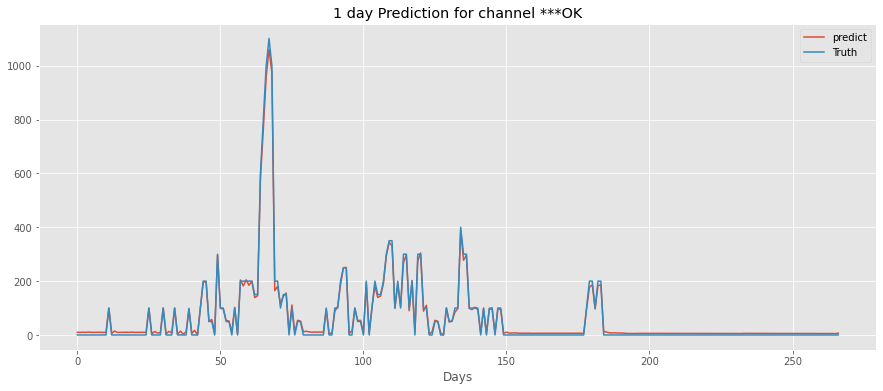

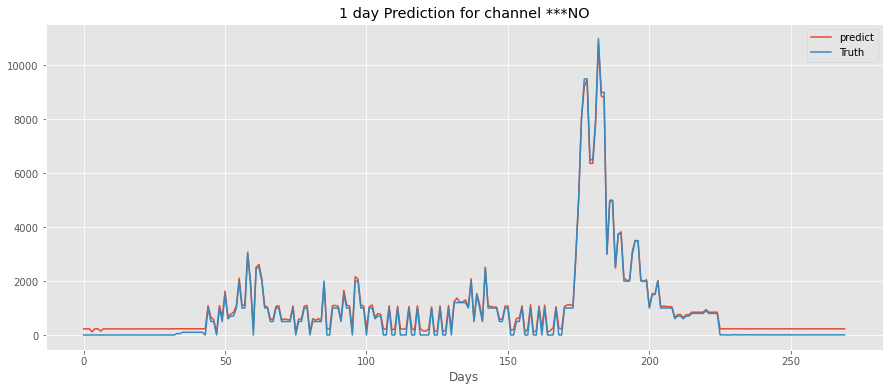

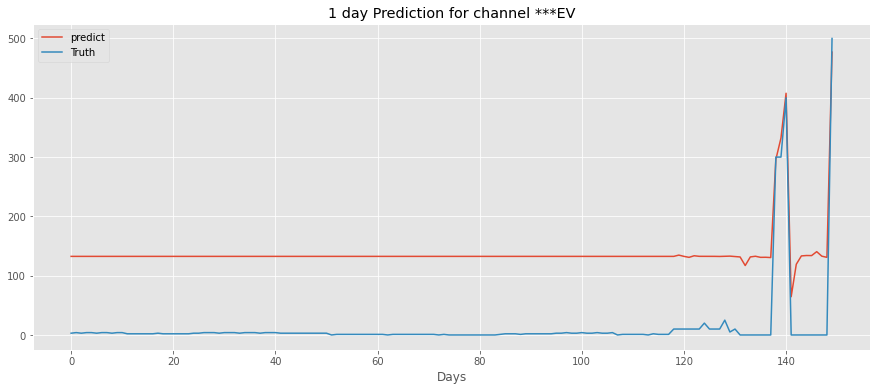

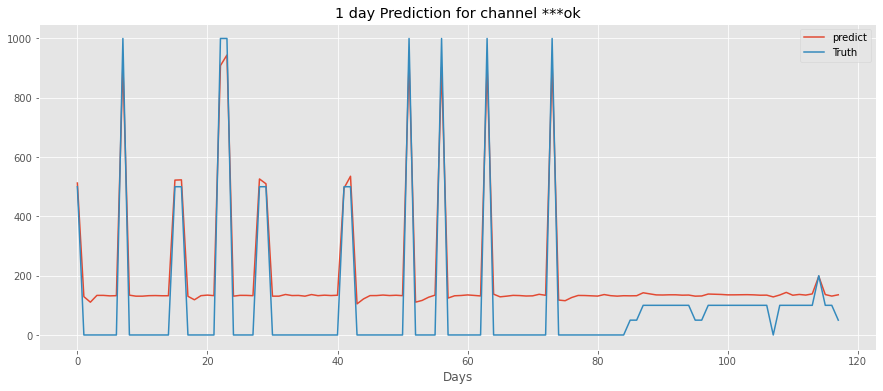

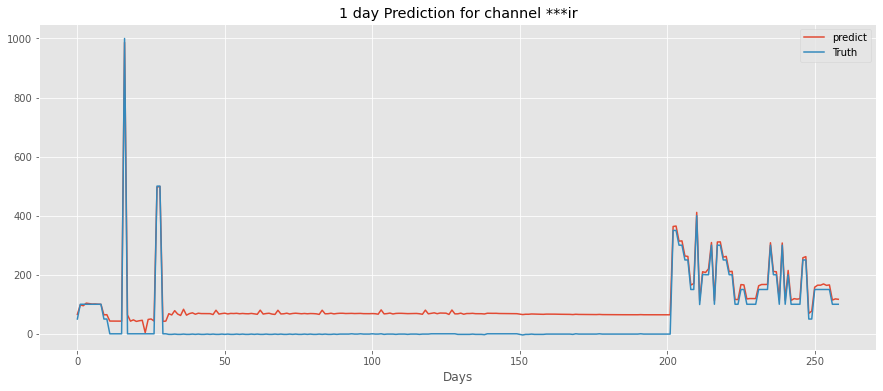

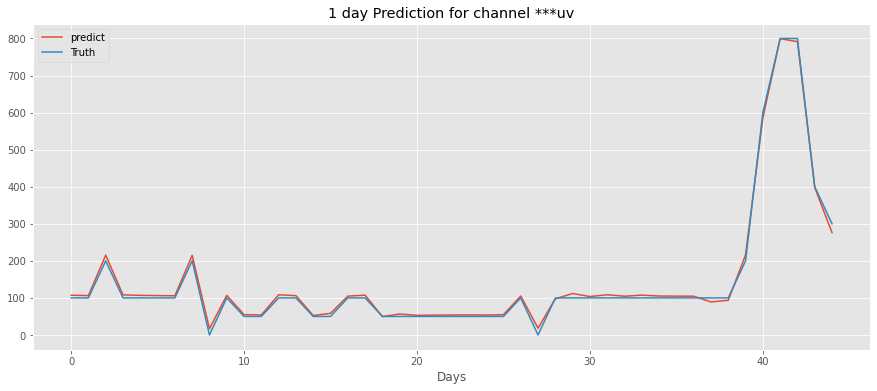

In [67]:
for i in range(15,25):
    X2,y2,scaler_X2,scaler_y2=preprocess_for_score2(X_180_1.iloc[channel_location[i]:channel_location[i+1]], y_180_1.iloc[channel_location[i]:channel_location[i+1]], targetsize)# 데이터는 get_loaded 한경우
    plt.figure(figsize=(15,6))

    plt.plot(scaler_y2.inverse_transform(loaded_model11.predict(X2)[:,-1].reshape(1,-1)).flatten(), label='predict') # 91일 ~ 끝까지. 
    plt.plot(scaler_y2.inverse_transform(y2[:,-1].reshape(1,-1)).flatten(), label='Truth')

    plt.legend()

    plt.title('1 day Prediction for channel ***'+'{}'.format(channel_name[i])[-2:])
    plt.xlabel('Days')

> 모델불러오기

In [216]:
path='Checkpoint/'+'Wavenet(90_30_1).h5'
loaded_model = tf.keras.models.load_model(path,custom_objects={'customLoss1':last_time_step_mse},compile=False)
loaded_model.compile(optimizer='adam', loss='mae',metrics=[last_time_step_mse])

> no scaling mae, rmse

In [219]:
predict_90_30_temp=loaded_model.predict(X_90_30_test)
predict_90_30=predict_90_30_temp[:,-1,:] # 마지막 step의 예측값
truth_90_30=y_90_30_test[:,-1,:] # 마지막 step의 실제값

rescaled_predict_90_30=scaler_y_90_30.inverse_transform(predict_90_30) # 역스케일링
rescaled_truth_90_30=scaler_y_90_30.inverse_transform(truth_90_30) # 역스케일링


In [233]:
print('30일간의 rmse --> ',np.sqrt(np.mean(keras.metrics.mean_squared_error(rescaled_predict_90_30[:],rescaled_truth_90_30[:]))))
print('30일간의 mae --> ',np.mean(keras.metrics.mean_absolute_error(rescaled_predict_90_30[:],rescaled_truth_90_30[:])))
print('30일 뒤 하루의 rmse --> ',np.sqrt(keras.metrics.mean_squared_error(rescaled_predict_90_30[:,-1],rescaled_truth_90_30[:,-1])))
print('30일 뒤 하루의 mae --> ',np.mean((keras.metrics.mean_absolute_error(rescaled_predict_90_30[:,-1],rescaled_truth_90_30[:,-1]))))



30일간의 rmse -->  1384.030292278158
30일간의 mae -->  159.70039784470907
30일 뒤 하루의 rmse -->  1471.6276825082625
30일 뒤 하루의 mae -->  174.3042859079849


#### Fitting 비교는 우선 나중에.

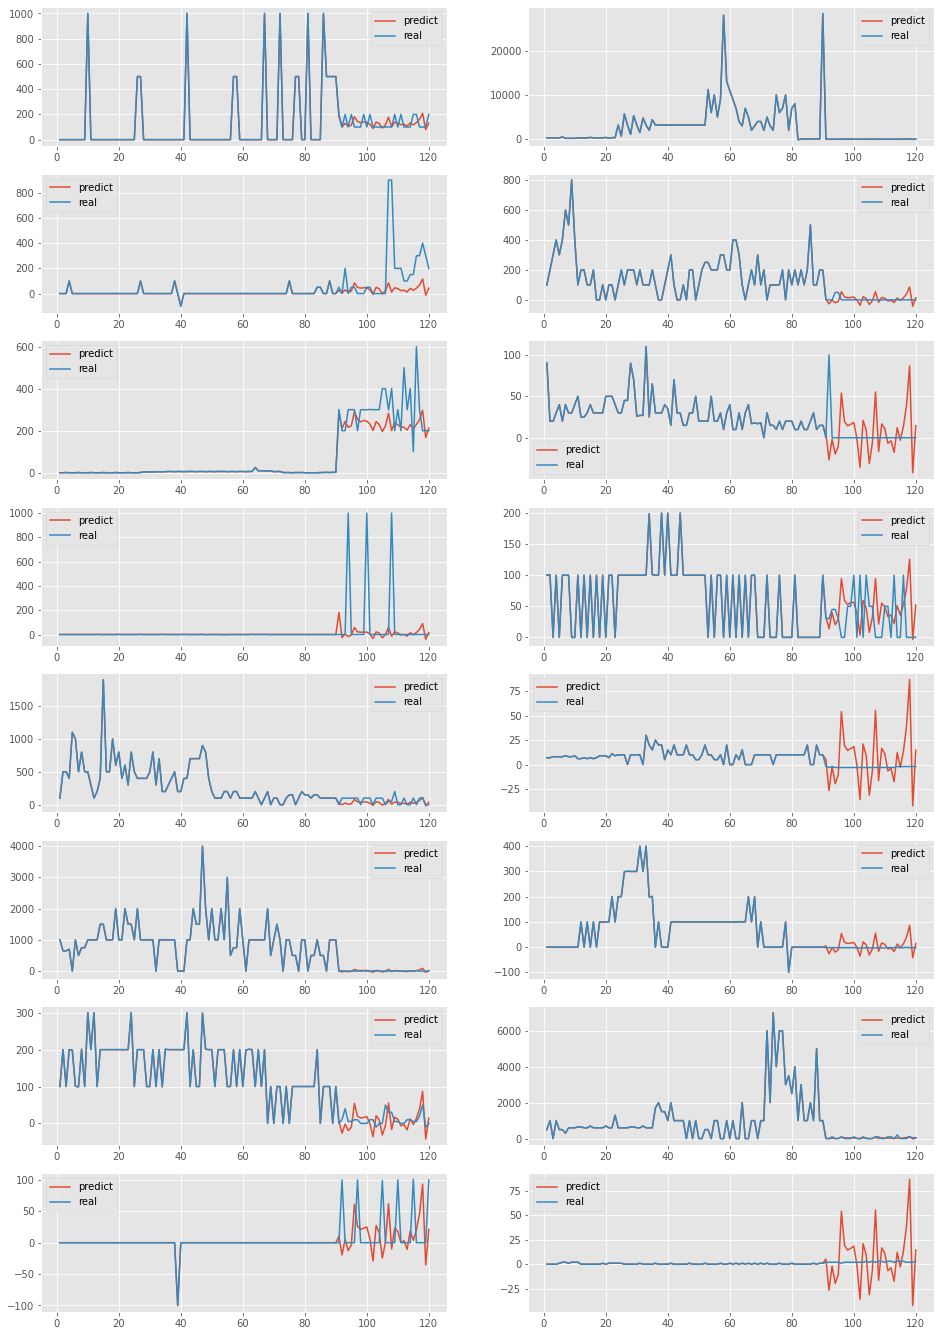

In [209]:
# rescaled_fitting
test_predict_temp=loaded_model.predict(X_90_30_test[48:64])
test_predict=np.concatenate([X_90_30_test[:16,:,-2],test_predict_temp[:,-1,:]],axis=1)
real_target1=np.concatenate([X_90_30_test[:16,:,-2],y_90_30_test[48:64,-1,:]],axis=1)
test_predict=scaler_y_90_30.inverse_transform(test_predict)
real_target1=scaler_y_90_30.inverse_transform(real_target1)
plt.figure(figsize=(16,24))
for i in range(len(real_target1)):
        plt.subplot(8,2,i+1)
        plt.plot(np.arange(1,filtersize+targetsize+1),test_predict[i,:],label='predict')
        plt.plot(np.arange(1,targetsize+filtersize+1),real_target1[i],label='real')
        
        plt.legend()

>scaled

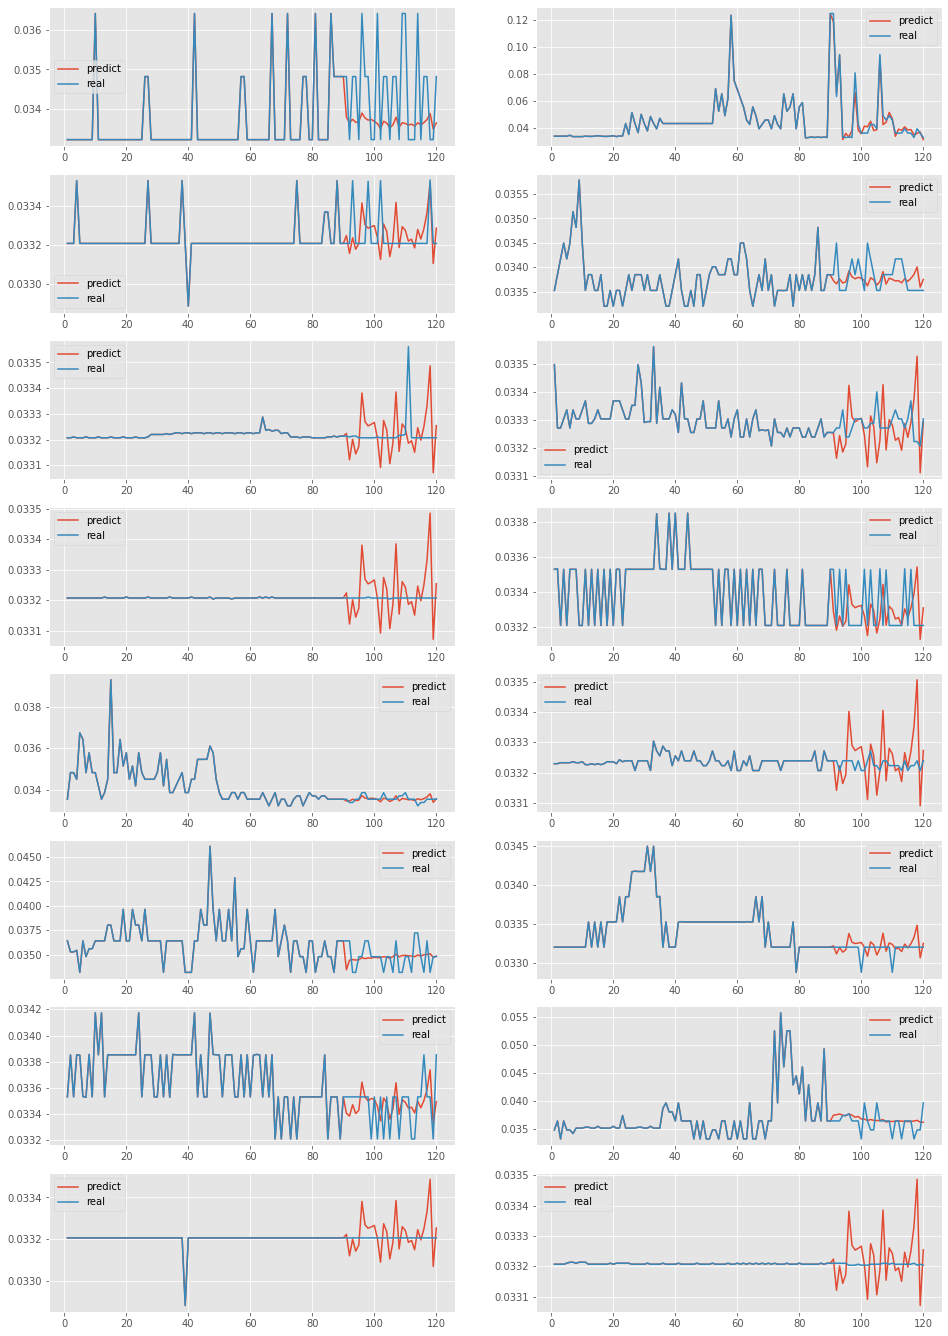

In [140]:
test_predict_temp=loaded_model.predict(X_90_30_test[:16])
test_predict=np.concatenate([X_90_30_test[:16,:,-2],test_predict_temp[:,-1,:]],axis=1)
real_target1=np.concatenate([X_90_30_test[:16,:,-2],y_90_30_test[:16,-1,:]],axis=1)
plt.figure(figsize=(16,24))
for i in range(len(real_target1)):
        plt.subplot(8,2,i+1)
        plt.plot(np.arange(1,filtersize+targetsize+1),test_predict[i,:],label='predict')
        plt.plot(np.arange(1,targetsize+filtersize+1),real_target1[i],label='real')
        
        plt.legend()
    

## Wavenet,Conv 모식도